In [1]:
# Imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.graphics.tsaplots as tsa
import statsmodels.api as sm
import bs4 as bs
import requests
import quantstats as qs

In [2]:
# FUNCTIONS USED
def print_full( x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


def calculate_MaxDD(dataframe, multi_frame=False, num_frames=1):
    """
    Calculates the drawdown statistics for an asset or strategy
    Parameters
    ===========
    dataframe: Pandas DataFrame
        Cumulative Return dataframe for portfolio/strategy 

    multi_frame: Bool
        If set True, multiple drawdowns will be calculated (all columns in dataframe)
    
    num_frames: Int
        Number of columns interating through to calculate statistics

    Returns
    ===========
    Max Drawdown, Max Drawdown Duration and Date of Max Drawdown
    """
    if multi_frame==False:
        cumreturn = dataframe
        highwatermark = np.zeros(cumreturn.shape)
        drawdown = np.zeros(cumreturn.shape)
        drawdownduration = np.zeros(cumreturn.shape)

        for t in np.arange(1, cumreturn.shape[0]):
            highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
            drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
            if drawdown[t] == 0:
                drawdownduration[t] = 0
            else:
                drawdownduration[t] = drawdownduration[t - 1] + 1

        maxDD, i = np.min(drawdown), np.argmin(drawdown)
        maxDDD = np.max(drawdownduration)
        DD_Date = cumreturn.index[i]
        print(f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}\n")

    else:
        for i in range(num_frames): 
            cumreturn = dataframe.iloc[:,i]
            highwatermark = np.zeros(cumreturn.shape)
            drawdown = np.zeros(cumreturn.shape)
            drawdownduration = np.zeros(cumreturn.shape)

            for t in np.arange(1, cumreturn.shape[0]):
                highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
                drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
                if drawdown[t] == 0:
                    drawdownduration[t] = 0
                else:
                    drawdownduration[t] = drawdownduration[t - 1] + 1

            maxDD, i = np.min(drawdown), np.argmin(drawdown)
            maxDDD = np.max(drawdownduration)
            DD_Date = cumreturn.index[i]
            print(f"{cumreturn.name}:")
            print(f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}\n")
            print("_____________\n")


def underwater_plot(dataframe, multi_frame=False, num_frames=1):
    """
    Plots the drawdown profile of an asset from the asset price dataframe
    Parameters
    ===========
    dataframe: Pandas DataFrame
        Cumulative Return dataframe for portfolio/strategy 

    multi_frame: Bool
        If set True, multiple drawdowns will be calculated and plotted(all columns in dataframe)
    
    num_frames: Int
        Number of columns interating through to plot drawdowns

    Returns
    ===========
    plot: underwater plot of drawdown profile for strategy/portfolio
    """
    if multi_frame==False:
        cum_max = dataframe.cummax()
        drawdowns = (dataframe - cum_max) / cum_max
        drawdowns = round(drawdowns,2)

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(drawdowns.index, drawdowns, color="lightcoral")
        ax.fill_between(drawdowns.index, drawdowns, 0, where=drawdowns < 0, interpolate=True, color="whitesmoke")
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        ax.grid()
        ax.set_xlim(min(dataframe.index),max(dataframe.index))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        colors = ['red', 'blue', 'green', 'orange', 'lightblue', 'grey', 'black']
        for i in range(num_frames): 
            cum_max = dataframe.iloc[:,i].cummax()
            drawdowns = (dataframe.iloc[:,i] - cum_max) / cum_max
            drawdowns = drawdowns
            ax.plot(drawdowns.index, drawdowns, color=colors[i], label=dataframe.columns[i])
        ax.legend(loc=0)
        ax.grid()
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
        ax.set_xlim(min(dataframe.index),max(dataframe.index))

    
def rolling_corr(price_dataframe, column_one, column_two, timeframe):
    """ Plot the rolling (log return) correlation for an asset pair
    Parameters
    ===========
    column_one: str
        First asset price column name from the dataframe needed

    column_two: str
        Second asset price column name from dataframe needed

    timeframe: int
        Timeframe for rolling correlation (number of days)

    Returns
    ===========
    Rolling Correlation: Line Plot
    """

    df = price_dataframe[[column_one, column_two]]
    df[column_one + '_log_ret'] = np.log(df[column_one] / df[column_one].shift())
    df[column_two + '_log_ret'] = np.log(df[column_two] / df[column_two].shift())
    df.drop(columns=[column_one, column_two], inplace=True)
    df.dropna(inplace=True)

    corr = df[column_one + '_log_ret'].rolling(timeframe).corr(df[column_two + '_log_ret'])

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(corr, color="darkblue")
    ax.axhline(df.corr().iloc[0, 1], c='r', ls='--')
    ax.set_title(f'Rolling {timeframe} Day Correlation', fontsize=13)
    ax.set_xlabel('Date')
    ax.set_ylabel('Correlation')
    ax.grid(color='lightgrey')
    ax.set_xlim(corr.index[0 + timeframe], max(df.index))
    plt.show()


def calculate_momentum_difference(price_dataframe, roll_periods=[20, 252]):
    
    signal_dataframe = pd.DataFrame(index=price_dataframe.index, columns=[])
    month_dataframe = pd.DataFrame(index=price_dataframe.index, columns=[])
    ann_dataframe = pd.DataFrame(index=price_dataframe.index, columns=[])
    for stock in price_dataframe.columns:
        # training[stock] = np.log(training[stock]/training[stock].shift(1))
        # monthly_roll = price_dataframe[stock].pct_change(periods=roll_periods[0])
        # month_dataframe[f'{stock}'] = monthly_roll.shift(1)
        # ann_roll = price_dataframe[stock].pct_change(periods=roll_periods[1])
        # ann_dataframe[f'{stock}'] = ann_roll.shift(1)
        # signal_dataframe[f'{stock}'] = (monthly_roll/ann_roll).shift()
        monthly_roll = price_dataframe[stock].shift(-roll_periods[0])
        ann_roll = price_dataframe[stock].shift(-roll_periods[1])
        signal_dataframe[f'{stock}'] = (monthly_roll/ann_roll).shift()
    
    signal_dataframe.dropna(axis=1, how='all', inplace=True)
    signal_dataframe.fillna(value=0, inplace=True) 
    signal_dataframe = signal_dataframe.replace([np.inf, -np.inf], 0)
    signal_dataframe = signal_dataframe.iloc[max(roll_periods):, :]
    return signal_dataframe, month_dataframe, ann_dataframe


def calculate_rolling_vol(dataframe, window):
    std_df = dataframe.pct_change().rolling(window).std().shift()[window:]
    std_df.dropna(axis=1, how='all', inplace=True) 
    std_df.fillna(value=0, inplace=True) 
    std_df.replace([np.inf, -np.inf], 0, inplace=True) 
    return std_df


def data_checking(df_dict, percent_missing=0.4, min_stocks=10):
    # Checking all stocks are accounted for 
    count = 0
    for key in df_dict:
        count += len(df_dict[key].columns)
    print(f'Number of stocks included: {count}')

    # Checking for missing values
    for key in df_dict:
        temp = df_dict[key]
        if temp.iloc[1,:].isna().sum() / len(temp.iloc[1,:]) > percent_missing:
            print(f'{key} has more than 40% of stocks with missing values ({round(temp.iloc[1,:].isna().sum() / len(temp.iloc[1,:]),3)*100}%)')
        else:
            print('No more missing values at start or end of frame')

    # Checking for stocks with less than 10 stocks
    for key in df_dict:
        num_tickers = len(df_dict[key].columns)
        if num_tickers < min_stocks:
            print(f'{key} has less than 10 stocks ({num_tickers})')


def rank_momentum_signal(signal_dict, returns_dict, dict=True, ls_skew = [0.2, 0.1], regime_df=None):  # num_longs_shorts=5
    if dict:
        ranked_df = {sector: pd.DataFrame(index=signal_dict[sector].index, columns=signal_dict[sector].columns) for sector in signal_dict}
        num_securities_held = {sector: [] for sector in signal_dict}
        
        for sector in ranked_df:
            signal_dict[sector].fillna(0, inplace=True)
            rank = signal_dict[sector].rank(axis=1, method='first', ascending=False)
            
            num_assets = len(signal_dict[sector].columns)
            temp = regime_df.loc[signal_dict[sector].index[0]:signal_dict[sector].index[-1],:]
            for index, row in temp.iterrows():
                if row['Regime'] == 1: # bull market
                    top_perc = int(ls_skew[0] * num_assets)
                    bottom_perc = int((1-ls_skew[1]) * num_assets)
                    ranked_df[sector].loc[index] = np.where(rank.loc[index, :]  < top_perc, 1, np.where(rank.loc[index, :]  > bottom_perc, -1, 0))
                else:
                    top_perc = int(ls_skew[1]  * num_assets)
                    bottom_perc = int((1-ls_skew[0]) * num_assets)
                    ranked_df[sector].loc[index] = np.where(rank.loc[index, :]  < top_perc, 1, np.where(rank.loc[index, :]  > bottom_perc, -1, 0))
                    
            
            num_longs_shorts = top_perc + (num_assets - bottom_perc)
            num_securities_held[sector].append(num_longs_shorts)
            # ranked_df[sector] = np.where(rank < top_perc, 1, np.where(rank > bottom_perc, -1, 0))
   
        momentum_selection = {sector: returns_dict[sector] * ranked_df[sector] for sector in returns_dict}
        
    return ranked_df, num_securities_held, momentum_selection, rank


def portfolio_weighting_scheme(portfolio_selections, securities_per_sector, weight_scheme='Equal_Weight', 
                               dict=True, price_df=None, vol_window=None, rebal_period=None, vol_target=None, 
                               regime=None, regime_df=None):
    '''
    weight_scheme: str
        Weighting scheme for the portfolio. Options include: Equal_Weight or volatility-scaled
    '''
    
    # Portolfio Construction
    if dict:
        portfolio = pd.DataFrame()
        if weight_scheme == 'equal_weight':
            for sector in portfolio_selections:
                if regime:
                    temp = regime_df.loc[portfolio_selections[sector].index[0]:portfolio_selections[sector].index[-1],:]
                    for col in portfolio_selections[sector].columns:
                        portfolio_selections[sector][col] *= temp.values.flatten()
                    portfolio[sector] = ((1+portfolio_selections[sector]).prod(axis=1)-1) / securities_per_sector[sector][0]
                else:
                    portfolio[sector] = ((1+portfolio_selections[sector]).prod(axis=1)-1) / securities_per_sector[sector][0]
                
        elif weight_scheme == 'vol_targeted':
            
            for sector in price_df:
                std_df = calculate_rolling_vol(price_df[sector], window=vol_window) * np.sqrt(252)
                std_df.index = pd.to_datetime(std_df.index)
                std_df = std_df.resample(rebal_period).mean()
                std_df = std_df.loc[portfolio_selections[sector].index[0]:portfolio_selections[sector].index[-1],:] 
                vol_targeted = vol_target / std_df
                vol_targeted = vol_targeted.replace([np.inf, -np.inf], 0)
                vol_targeted.fillna(0, inplace=True)
                weighted_returns = (vol_targeted * portfolio_selections[sector].values) / securities_per_sector[sector][0] # no more than 100% exposure

                if regime:
                    temp = regime_df.loc[portfolio_selections[sector].index[0]:portfolio_selections[sector].index[-1],:]
                    for col in range(weighted_returns.shape[1]):
                        weighted_returns.iloc[:,col] *= temp.values.flatten()
                    # portfolio[sector] = ((1+portfolio_selections[sector]).prod(axis=1)-1) / securities_per_sector[sector][0]
                    portfolio[sector] = ((1+weighted_returns).prod(axis=1)-1) / len(price_df)
                
                else:
                    portfolio[sector] = ((1+weighted_returns).prod(axis=1)-1) / len(price_df)

    else:
        if weight_scheme == 'equal_weight':
            portfolio = ((1+portfolio_selections).prod(axis=1)-1) / securities_per_sector
        elif weight_scheme == 'vol_targeted':
            std_df = calculate_rolling_vol(price_df, window=vol_window) * np.sqrt(252)
            std_df.index = pd.to_datetime(std_df.index)
            std_df = std_df.resample(rebal_period).mean()
            std_df = std_df.loc[portfolio_selections.index[0]:portfolio_selections.index[-1],:] 
            vol_targeted = vol_target / std_df
            vol_targeted = vol_targeted.replace([np.inf, -np.inf], 0)
            vol_targeted.fillna(0, inplace=True)
            weighted_returns = (vol_targeted * portfolio_selections.values) / securities_per_sector # no more than 100% exposure

            if regime:
                temp = regime_df.loc[portfolio_selections.index[0]:portfolio_selections.index[-1],:]
                for col in range(weighted_returns.shape[1]):
                    weighted_returns.iloc[:,col] *= temp.values.flatten()
                portfolio = ((1+weighted_returns).prod(axis=1)-1) #/ price_df.shape[1]
            
            else:
                portfolio = ((1+weighted_returns).prod(axis=1)-1)

    return portfolio


def add_transaction_costs(survivorship_bias = True, rebalance_freq = 'M', dataframe = pd.DataFrame(), target_costs = 0.03): # calc_weights=False, weight_scheme='Equal_Weight'
            
    if survivorship_bias:
        if rebalance_freq == 'D':
            dataframe = dataframe - 0.0001173 - (pow(1+target_costs, 1/252)-1)
        elif rebalance_freq == 'W':
            dataframe = dataframe - 0.000591 - (pow(1+target_costs, 1/50)-1)
        elif rebalance_freq == 'M':
            dataframe = dataframe - 0.002466 - (pow(1+target_costs, 1/12)-1)
    else:
        if rebalance_freq == 'D':
            dataframe = dataframe - (pow(1+target_costs, 1/252)-1)
        elif rebalance_freq == 'W':
            dataframe = dataframe - (pow(1+target_costs, 1/50)-1)
        elif rebalance_freq == 'M':
            dataframe = dataframe - (pow(1+target_costs, 1/12)-1)

    return dataframe

# Part 1: Creating my null model

## Long-Short Sector Neatural Momentum Strategy

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Regime model starts in 1990 so I will start my stock data there
regime = pd.read_csv('1_hidden_states.csv', index_col='Date')
regime.index = pd.to_datetime(regime.index)
regime = regime.resample('W').last()
regime.head(3)

Regime
Date              
1990-01-14       0
1990-01-21       0
1990-01-28       0

In [4]:
risk_free_rate = pd.read_csv('RiskFreeRatew.csv',  index_col='DATE')
risk_free_rate.rename({'DFF':'Rate'}, inplace=True)
risk_free_rate.index = pd.to_datetime(risk_free_rate.index)
risk_free_rate = risk_free_rate.resample('W').last()
risk_free_rate = risk_free_rate / 100
risk_free_rate = risk_free_rate.loc[regime.index[0]:regime.index[-1],:]

# Scrapping Wiki for ticker names and sector to build portfolio using BeautifulSoup
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
tickers = [s.replace('\n', '') for s in tickers]
print(len(tickers))

# stock_data = yf.download(tickers, start='1990-01-01', end='2024-02-27').Close
# stock_data.drop(['GOOGL'], axis=1, inplace=True)
# stock_data.to_csv('sp500_stocks.csv', index=True)

# Reading in the scrapped data
stock_data = pd.read_csv('sp500_stocks.csv', index_col='Date')
stock_data = stock_data.apply(pd.to_numeric, errors='coerce')
stock_data.dropna(axis=1, how='all', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)
stock_data.head(3) 

503


A  AAL  AAPL  ABBV  ABNB   ABT  ACGL  ACN  ADBE   ADI  ...  WYNN  \
Date                                                                ...         
1990-01-02 NaN  NaN  0.33   NaN   NaN  3.89   NaN  NaN  1.27  1.60  ...   NaN   
1990-01-03 NaN  NaN  0.33   NaN   NaN  3.90   NaN  NaN  1.33  1.52  ...   NaN   
1990-01-04 NaN  NaN  0.34   NaN   NaN  3.89   NaN  NaN  1.39  1.50  ...   NaN   

              XEL    XOM  XRAY  XYL  YUM  ZBH  ZBRA  ZION  ZTS  
Date                                                            
1990-01-02  20.25  12.50  1.04  NaN  NaN  NaN   NaN  3.50  NaN  
1990-01-03  20.19  12.38  1.04  NaN  NaN  NaN   NaN  3.56  NaN  
1990-01-04  19.69  12.25  1.00  NaN  NaN  NaN   NaN  3.56  NaN  

[3 rows x 500 columns]

In [5]:
# Scrape Wiki for sector classification of each stock
resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
sectors = []
for row in table.findAll('tr')[1:]:
    sectors.append(row.findAll('td')[2].text)
sectors = [s.replace('\n', '') for s in sectors]
sectors = pd.DataFrame(sectors, index=tickers, columns=['Sector'])

# Split stocks by sector
sectors['Stocks'] = sectors.index
sectors.drop('Stocks', axis=1, inplace=True)

stocks_sectors = {'Industrials': [],'Health Care': [],'Information Technology': [],'Utilities': [],'Financials': [],'Materials': [],
                'Consumer Discretionary': [],'Real Estate': [],'Communication Services': [],'Consumer Staples': [], 'Energy': []}

# Make the sectors the columns
for i in range(sectors.shape[0]):
    if sectors['Sector'][i] in stocks_sectors:
        stocks_sectors[sectors.Sector[i]].append(sectors.index[i])
stocks_sectors['Industrials'][:5]

['MMM', 'AOS', 'ALLE', 'AAL', 'AME']

## Autocorrelation

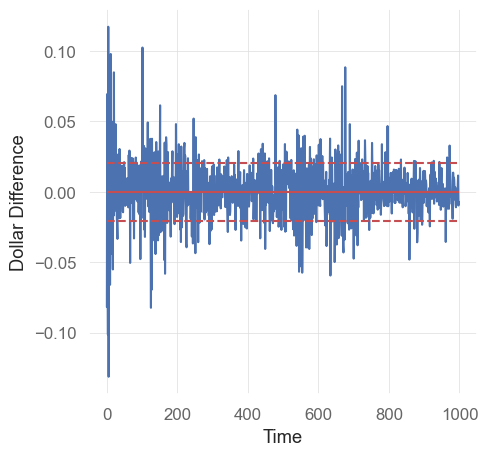

In [6]:
temp = stock_data.iloc[-1000:,:100].dropna(axis=1, how='any').pct_change().dropna()
dates = temp.index

# Find the line of best fit to illustrate the trend
X = np.arange(len(dates))
x = sm.add_constant(X) 
model = sm.regression.linear_model.OLS(temp['AAPL'].values, x).fit()
a = model.params[0] 
b = model.params[1]
y_hat = X * b + a

plt.figure(figsize=(5,5))
plt.plot((temp['AAPL'] - y_hat).values)
plt.hlines(np.mean(temp['AAPL']- y_hat), 0, len(dates), colors='r')
plt.hlines(np.std(temp['AAPL'] - y_hat), 0, len(dates), colors='r', linestyles='dashed')
plt.hlines(-np.std(temp['AAPL'] - y_hat), 0, len(dates), colors='r', linestyles='dashed')
plt.xlabel('Time')
plt.ylabel('Dollar Difference')
plt.show()

In [7]:
from statsmodels.stats.stattools import durbin_watson

no_ac_count = 0
for stock in temp:

    X = np.arange(len(dates))
    x = sm.add_constant(X) 
    model = sm.regression.linear_model.OLS(temp[stock].values, x).fit()
    a = model.params[0] 
    b = model.params[1]
    y_hat = X * b + a
    residuals = (temp['AAPL'] - y_hat).values

    test_stat = durbin_watson(residuals)
    if test_stat == 2:
        no_ac_count += 1

no_ac_count

0

## Cross-sectional Momentum Scoring strategy
- My base (null) model that I want the Neural Network to beat is a 12mth-1mth momentum strategy (long-short)
- I will compare each new model against where theres a trade off between complexity and performance. 
- I am constructing a portfolio based on cross-sectional momentum, where assets (stocks in each sector) are bought depending on relative rank to other assets (as opposed to time series momentum (TSMOM) to replicate a typical CTA strategy). 

**Definitions**
-	*TSMOM/Trend-Following*: Buying securities based on its own current strength
-	*Cross-Sectional momentum*: Buying securities based on momentum score relative to other assets. 0 correlation to carry and 0.3 to TSMOM strategies

**Base model (12mth-1mth momentum) rules**;
- Score momentum cross-sectionally
- Rank score within each sector
- Long top 20%tile and short bottom 20%tile in each sector

**Portfolio Construction**:
- Equal weight across sector, but equal-weight/vol-scaled within sector
- If regime tells us to get out of the market, let cash grow at the prevaling risk free rate (Fed Funds Rate)

## Data Preparation

Because of the survivorship bias in the data I will drop na rows as I go and build a strategy based on sector numbers. Anomalies will be dealt with later

First lets check the correlation in rolling returns, to justify which to use as inputs to the model

<Axes: >

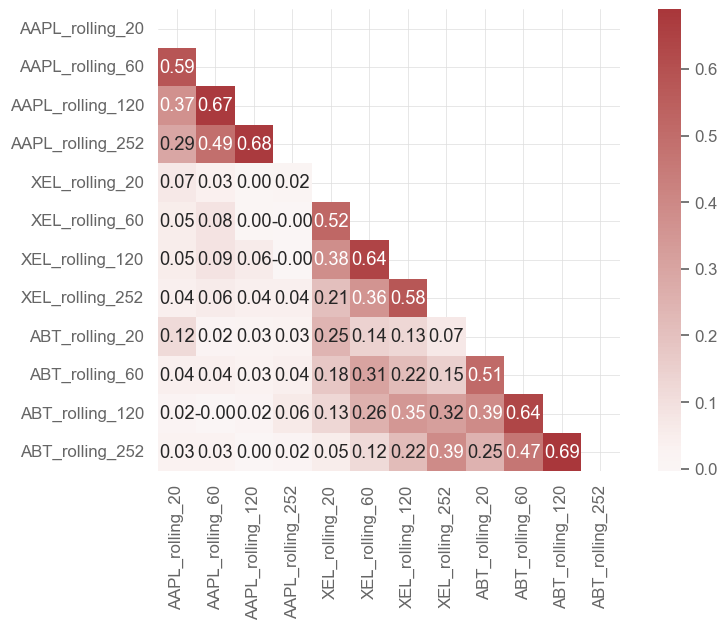

In [8]:
# Checking for correlation in rolling returns
roll_periods = [20,60,120,252]
temp = pd.DataFrame(index=stock_data.index, columns=[])
for stock in ['AAPL', 'XEL', 'ABT']:
    for period in roll_periods:
        price_change = stock_data[stock].pct_change()
        temp[f'{stock}_rolling_{period}'] = (1+price_change).rolling(window=period).apply(np.prod, raw=True).shift(1) - 1

temp.dropna(axis=1, how='all', inplace=True)
corr_matrix = temp.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap='vlag')

- There is visibly high correlation between slower rolls (120 and 252 day ) and faster rolls (20 and 60 days). So lets only use 20 and and 252 as base model (12-1mth returns)
- Its good to see lower correlation betweend different stocks

In [9]:
signal, monthly_df, ann_df = calculate_momentum_difference(roll_periods=[20, 252], price_dataframe=stock_data)

# Resampling for a monthly rebalance
rebal_period = 'W'
signal.index = pd.to_datetime(signal.index)
signal = signal.resample(rebal_period).last()
signal.head(3)

A  AAL      AAPL  ABBV  ABNB       ABT  ACGL  ACN      ADBE  \
Date                                                                        
1991-01-06  0.0  0.0  0.943396   0.0   0.0  0.646358   0.0  0.0  0.562648   
1991-01-13  0.0  0.0  0.928571   0.0   0.0  0.687075   0.0  0.0  0.626904   
1991-01-20  0.0  0.0  0.910714   0.0   0.0  0.733906   0.0  0.0  0.678663   

                 ADI  ...  WYNN       XEL       XOM      XRAY  XYL  YUM  ZBH  \
Date                  ...                                                      
1991-01-06  0.861842  ...   0.0  0.780636  0.860667  0.392727  0.0  0.0  0.0   
1991-01-13  0.912500  ...   0.0  0.811303  0.924983  0.383333  0.0  0.0  0.0   
1991-01-20  0.832370  ...   0.0  0.859920  0.909337  0.391156  0.0  0.0  0.0   

            ZBRA      ZION  ZTS  
Date                             
1991-01-06   0.0  0.786667  0.0  
1991-01-13   0.0  0.854251  0.0  
1991-01-20   0.0  0.834545  0.0  

[3 rows x 498 columns]

In [10]:
# Resampling stock data to weekly (equal to the rebalance frequency)
rebal_return_data = stock_data.copy()
rebal_return_data.index = pd.to_datetime(rebal_return_data.index)
rebal_return_data = rebal_return_data.resample(rebal_period).last().pct_change()
rebal_return_data.dropna(axis=1, how='all', inplace=True) # dropping all fully na columns
rebal_return_data.fillna(value=0, inplace=True) # filling na values with 0
rebal_return_data = rebal_return_data.replace([np.inf, -np.inf], 0) # replacing inf values with 0
rebal_return_data = rebal_return_data.loc[signal.index[0]:,:]
rebal_return_data.iloc[0,:] = 0 
rebal_return_data.head(3)

A  AAL      AAPL  ABBV  ABNB       ABT  ACGL  ACN      ADBE  \
Date                                                                        
1991-01-06  0.0  0.0  0.000000   0.0   0.0  0.000000   0.0  0.0  0.000000   
1991-01-13  0.0  0.0  0.076923   0.0   0.0  0.000000   0.0  0.0  0.108571   
1991-01-20  0.0  0.0  0.071429   0.0   0.0  0.050328   0.0  0.0  0.113402   

                 ADI  ...  WYNN       XEL       XOM      XRAY  XYL  YUM  ZBH  \
Date                  ...                                                      
1991-01-06  0.000000  ...   0.0  0.000000  0.000000  0.000000  0.0  0.0  0.0   
1991-01-13 -0.017391  ...   0.0 -0.029851 -0.031832  0.000000  0.0  0.0  0.0   
1991-01-20  0.035398  ...   0.0  0.015385  0.035285  0.061224  0.0  0.0  0.0   

            ZBRA      ZION  ZTS  
Date                             
1991-01-06   0.0  0.000000  0.0  
1991-01-13   0.0 -0.015748  0.0  
1991-01-20   0.0  0.034667  0.0  

[3 rows x 500 columns]

In [11]:
sector_split = {'Industrials': [],'Health Care': [],'Information Technology': [],'Utilities': [],'Financials': [],'Materials': [],
                'Consumer Discretionary': [],'Real Estate': [],'Communication Services': [],'Consumer Staples': [], 'Energy': []}

# Checking the tickers that have been dropped for the base model and create a new sector split dictionary
sector_split = {sector: [stock for stock in stocks_sectors[sector] if stock in signal.columns] for sector in stocks_sectors}
sector_signal = {sector: signal[sector_split[sector]] for sector in sector_split} # # Create a 12-1mth return signal split by sector

# Aligning returns data with signal dates
sector_returns = {sector: rebal_return_data[sector_split[sector]] for sector in sector_split}

data_checking(sector_signal, percent_missing=0.2, min_stocks=10)

Number of stocks included: 495
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame
No more missing values at start or end of frame


In [12]:
# Checking that all dataframes are aligned and have no missing values
count = 0
for i, j  in zip(sector_returns, sector_signal):
    if sector_returns[i].shape ==  sector_signal[j].shape:
        count += 1
    if sector_returns[i].isna().sum().sum() > 0:
        print(f'missing values in return data for {i}')
    if sector_signal[j].isna().sum().sum() > 0:
        print(f'missing values in signal data for {j}')
        
count

11

In [13]:
# Clip all anomalies - due to the nature of the data, we will clip the returns and signals to -10% and 10%
for sector in sector_signal:
    # sector_signal[sector] = sector_signal[sector].clip(lower=-0.1, upper=0.1, axis=0)
    sector_returns[sector] = sector_returns[sector].clip(lower=-0.1, upper=0.1, axis=0)

## Creating the Momentum model (Equal weight)

In [14]:
# Momentum Scoring cross-sectionally - Long best 5 and short worst 5 performing stocks in each sector
rank_dict, num_securities_held, momentum_selection, rank_percentile = rank_momentum_signal(signal_dict = sector_signal, returns_dict=sector_returns, dict=True, 
                                                                                           ls_skew=[0.2, 0.1], regime_df=regime)  

# Portolfio Construction - Equally Weighted
sector_split_portfolios = portfolio_weighting_scheme(weight_scheme='equal_weight', portfolio_selections=momentum_selection, 
                                                     securities_per_sector=num_securities_held, dict=True, regime=False, regime_df=regime)
sector_split_portfolios.tail(3)

Industrials Health Care Information Technology Utilities  \
Date                                                                  
2024-02-18   -0.004305    0.006499              -0.019623  0.010176   
2024-02-25    -0.00189   -0.001521               0.002468  -0.00664   
2024-03-03    0.000753   -0.001237              -0.000353 -0.003071   

           Financials Materials Consumer Discretionary Real Estate  \
Date                                                                 
2024-02-18  -0.004565    0.0026              -0.014282    0.003321   
2024-02-25   0.002453  0.002489              -0.002826   -0.005896   
2024-03-03   0.001028 -0.008078              -0.001674   -0.003657   

           Communication Services Consumer Staples    Energy  
Date                                                          
2024-02-18              -0.015326        -0.001466  -0.00105  
2024-02-25               0.025007         0.005397 -0.008176  
2024-03-03              -0.006948        -0.001866  -0.00575

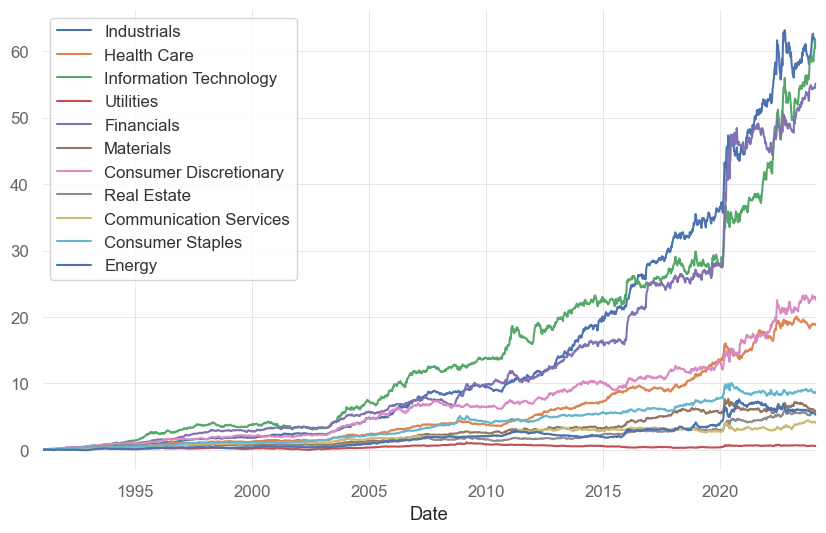

In [15]:
for sector in sector_split_portfolios:
    reggie = regime.loc[sector_split_portfolios[sector].index[0]:sector_split_portfolios[sector].index[-1],:]
    # sector_split_portfolios[sector] *= reggie.values.flatten()
    ((1+sector_split_portfolios[sector]).cumprod()-1).plot(label=sector)
plt.legend()

Costs for the strategies:
- -3% annualised penalisation for survivorship bias within my data (RESOURCE)
- -2% annualised transaction costs (bid-ask spread, fees/commission, market impact) for weekly trading strategy

In [16]:
rfr = risk_free_rate.loc[sector_split_portfolios[sector].index[0]:sector_split_portfolios[sector].index[-1],:]
temp = regime.loc[sector_split_portfolios[sector].index[0]:sector_split_portfolios[sector].index[-1],:]
rfr_toggle = np.where(temp==1,0,1)
rfr *= rfr_toggle # is regime = 0 (get out of market), then grow cash as risk-free rate

In [17]:
# Calculating the combined sector portfolio returns and adding transaction costs
num_sectors = len(rank_dict)
long_short_portfolio = (((1+sector_split_portfolios).cumprod(axis=1).iloc[:, -1] - 1))/num_sectors

sector_split_portfolios['Portfolio'] = add_transaction_costs(survivorship_bias = True, rebalance_freq = rebal_period, dataframe = long_short_portfolio, 
                                                             target_costs = 0.03) # regime.loc[long_short_portfolio.index[0]:long_short_portfolio.index[-1],:].values.flatten()

# sector_split_portfolios['Portfolio'] += (rfr.values.flatten()/52)

sector_split_portfolios.iloc[0,:] = 0
sector_split_portfolios.iloc[-1,:] = 0
sector_split_portfolios.tail(3)

Industrials Health Care Information Technology Utilities  \
Date                                                                  
2024-02-18   -0.004305    0.006499              -0.019623  0.010176   
2024-02-25    -0.00189   -0.001521               0.002468  -0.00664   
2024-03-03           0           0                      0         0   

           Financials Materials Consumer Discretionary Real Estate  \
Date                                                                 
2024-02-18  -0.004565    0.0026              -0.014282    0.003321   
2024-02-25   0.002453  0.002489              -0.002826   -0.005896   
2024-03-03          0         0                      0           0   

           Communication Services Consumer Staples    Energy Portfolio  
Date                                                                    
2024-02-18              -0.015326        -0.001466  -0.00105 -0.004619  
2024-02-25               0.025007         0.005397 -0.008176 -0.000227  
2024-03-03                      0                0         0         0

In [18]:
sector_split_portfolios.to_csv('null_portfolio_sector_results.csv', index=True)

In [19]:
df = yf.download(['^SPX','RSP'], period='max', interval='1d').Close
df = df.resample(rebal_period).last()
df = pd.DataFrame(df.pct_change())
df.index = pd.to_datetime(df.index)
df = df.loc[sector_split_portfolios.index[0]:, :]

[*********************100%%**********************]  2 of 2 completed


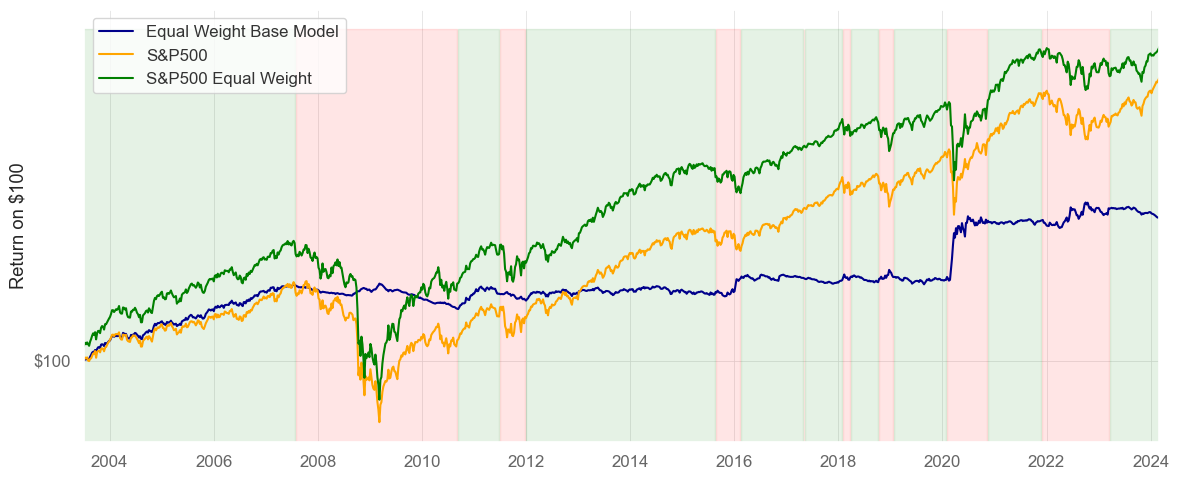

In [20]:
# Growth of $100 for the strategy versus the S&P500 and the Equal Weight S&P500 
strategy = (1+sector_split_portfolios['Portfolio'].loc['2003-06-30':]).cumprod() * 100
df2 = df.dropna()
spx = (1+df['^SPX'].loc['2003-06-30':]).cumprod() * 100
bmk = (1+df['RSP']).cumprod() * 100

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(strategy, label="Equal Weight Base Model", color="darkblue")
ax.plot(spx, label="S&P500", color="orange")
ax.plot(bmk, label="S&P500 Equal Weight", color="green")

# plot the different regime states using fill between
colors = ['red', 'green']
for i in range(2):
    ax.fill_between(regime.index, 0, 700, where=regime['Regime'] == i, alpha=0.1, color=colors[i])

ax.set_ylabel('Return on $100')
ax.set_yscale('log')
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(min(strategy.index),max(strategy.index))
ax.legend(loc=0)
plt.tight_layout()

In [21]:
# Correlation vs benchmarks
pd.DataFrame([sector_split_portfolios['Portfolio'].loc['2003-06-30':], df['^SPX'].loc['2003-06-30':], df['RSP'].loc['2003-06-30':]]).T.corr()

Portfolio      ^SPX       RSP
Portfolio   1.000000 -0.185421 -0.215619
^SPX       -0.185421  1.000000  0.969450
RSP        -0.215619  0.969450  1.000000

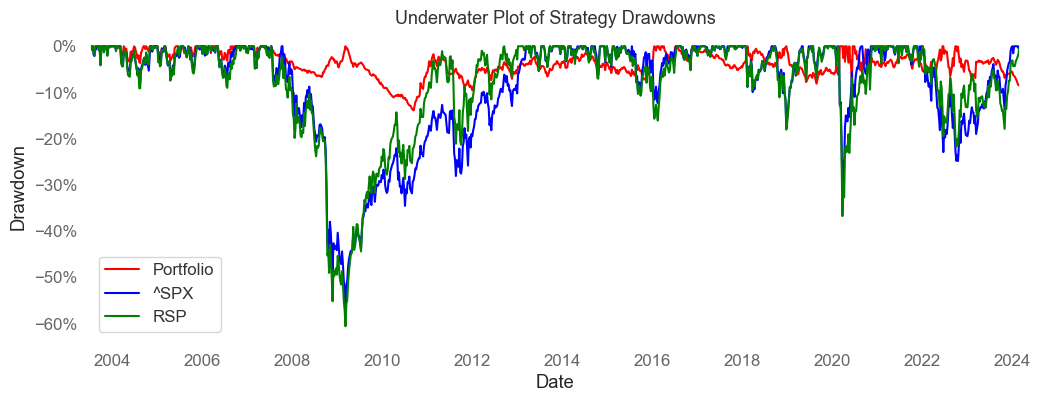

In [22]:
# Analysing the drawdown profile
cum_returns = pd.concat([strategy, spx, bmk], axis=1).dropna()
underwater_plot(cum_returns, multi_frame=True, num_frames=3)

Performance metrics:
| Metric                    | LS Strategy | ^SPX  | RSP   |
|---------------------------|-----------|-------|-------|
| Cumulative Return         | 130.84%   | 421.16% | 474.14% |
| CAGR%                     | 2.83%     | 5.67%  | 6.01%  |
| Sharpe                    | 1.3       | 1.21   | 1.17   |
| Prob. Sharpe Ratio        | 99.85%    | 99.24% | 99.11% |
| Sortino                   | 2.53      | 1.7    | 1.66   |
| Max Drawdown              | -13.87%   | -56.24% | -60.57% |
| Longest DD Days           | 2493      | 1982   | 1877   |
| Volatility (ann.)         | 15.98%    | 38.0%  | 42.79% |


In [23]:
# # qs.reports.plots(cum_returns, mode='basic')
# qs.reports.full(cum_returns, mode='full')

# **Part 2: Building the Neural Network**

## Feature Engineering:
- *ann_roll*: Past 12mth returns
- *monthly_roll*: Past 1mth returns
- *rank_percentile*: 12mth - 1mth return percentile/ranking (1 for the stock with the highest return in a month down to 0 for the stock with the lowest return in a month)
- *momentum_selection*: Return*selected momentum stocks; 

Goal: Output (predict) the return percentile for the subsequent week. 

This approach enables the NNs to calculate with numbers in a stable range between 0 and 1 rather than arbitrary real numbers
I dont want it to find the same pattern as my momentum signal, I am just looking at performance differential

Due to high correlation between stocks within sectors (whole sectors ususally move up and down jointly), the test sets measure of generalization error will be optimistically biased. Therefore I've opted to predict the next months returns for each sector through a benchmark, and beta adjust each stock according to the prediction in order to gain a momentum score.

## Predicting next months returns for each stock

In [24]:
prices = {sector: stock_data.dropna(how='all')[sector_split[sector]] for sector in sector_split} # price data split by sector NOT SHIFTED
weekly_returns = sector_returns # 1mth return dict split by sector NOT SHIFTED
# sector_benchmarks # SHIFTED
# betas # SHIFTED
# bmk_weekly_returns # SHIFTED

## **Neural Network**

**EXPLANATION IN OTHER FILE**

In [25]:
import tensorflow as tf
from keras import Model, activations
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1
from keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# tensorboard set up
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    run_id = strftime("run_%Y_%m_%d-%H_%M_%S")
    return Path(root_logdir) / run_id

run_logdir = get_run_logdir()

## Using RNN and LSTM to predict the sector benchmark return

### RNN

In [26]:
# Calculating the rolling 3mth daily beta of each stock to its synthetic benchmark (equal weight of all stocks in the sector)
def calculate_rolling_beta(price_data, window_size, resample):

    betas = {sector: pd.DataFrame() for sector in price_data}
    sector_benchmarks = {sector: pd.DataFrame() for sector in price_data}
    for sector in price_data:
        sector_benchmark = price_data[sector].resample(resample).last().pct_change().mean(axis=1).dropna()
        sector_benchmark = sector_benchmark.loc[weekly_returns[sector].index[0]:weekly_returns[sector].index[-1]]
        sector_benchmarks[sector] = sector_benchmark.shift()
        
        stock_returns = price_data[sector].pct_change()
        benchmark = price_data[sector].pct_change().mean(axis=1).dropna()
        rolling_beta = stock_returns.rolling(window=window_size).cov(benchmark) 
        for col in rolling_beta:
            rolling_beta[col] /= benchmark.rolling(window=window_size).var()
        beta = rolling_beta.dropna(how='all').resample(resample).mean().shift()
        betas[sector] = beta.loc[weekly_returns[sector].index[0]:weekly_returns[sector].index[-1],:]

    return betas, sector_benchmarks

# Calculate the rolling 3mth daily beta of each stock to the benchmark
betas, sector_benchmarks = calculate_rolling_beta(prices, window_size=60, resample=rebal_period)
betas['Industrials'].tail(3)

MMM       AOS      ALLE       AAL       AME       ADP  \
Date                                                                     
2024-02-18  1.077649  1.166834  1.335888  2.153227  0.928336  0.220136   
2024-02-25  1.084850  1.185774  1.419505  2.253563  0.923605  0.137933   
2024-03-03  1.047098  1.197160  1.355778  2.184212  0.924077  0.133560   

                AXON        BA        BR      BLDR  ...      UBER       UNP  \
Date                                                ...                       
2024-02-18  1.018420  0.497560  0.522468  2.066132  ...  1.105258  0.972325   
2024-02-25  1.103269  0.527037  0.550363  1.834591  ...  1.343624  0.955849   
2024-03-03  1.158103  0.511338  0.617532  1.824791  ...  1.614141  0.978290   

                 UAL       UPS       URI      VRSK       WAB        WM  \
Date                                                                     
2024-02-18  1.697484  1.077980  2.203824  0.191814  0.708153  0.363884   
2024-02-25  1.804173  1.058014  2.389749  0.257110  0.663471  0.202974   
2024-03-03  1.746172  0.994978  2.366609  0.255905  0.623415  0.148357   

                 GWW       XYL  
Date                            
2024-02-18  1.043250  1.078961  
2024-02-25  1.111024  1.140994  
2024-03-03  1.097437  1.148166  

[3 rows x 77 columns]

In [27]:
# Creating the annual and monthly rolling returns features for the sector benchmarks
bmk_weekly_returns = pd.DataFrame()
for sector in prices:
    bmk_weekly = prices[sector].resample(rebal_period).last().pct_change().shift()
    bmk_weekly = bmk_weekly.loc[weekly_returns[sector].index[0]:weekly_returns[sector].index[-1]].fillna(0)
    bmk_weekly_returns[sector] = bmk_weekly.mean(axis=1)

# Reducing returns by 3% (annualised) due to survivorship bias
bmk_weekly_returns -= 0.002466

In [28]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y


# Splitting into trian, validation and test sets
num_stocks = bmk_weekly_returns.shape[1]
n = bmk_weekly_returns.shape[0]
idx_train = int(0.7 * n)
idx_val = int(0.85 * n)        
X_train, X_val, X_test = bmk_weekly_returns.iloc[:idx_train, :], bmk_weekly_returns.iloc[idx_train:idx_val, :], bmk_weekly_returns.iloc[idx_val:, :]

# Scaling the data
ss_scaler = StandardScaler()
X_train = ss_scaler.fit_transform(X_train)
X_val = ss_scaler.transform(X_val)
X_test = ss_scaler.transform(X_test)

# Splitting the data into batches
return_window=4
X_train, y_train = create_multivariate_rnn_data(X_train, return_window)
X_val, y_val = create_multivariate_rnn_data(X_val, return_window)
X_test, y_test = create_multivariate_rnn_data(X_test, return_window)

In [29]:
# Checking shapes align - (batch size, time, no outputs/sectors) i.e. (samples, lookback, features)
X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape

((1207, 4, 11), (256, 4, 11), (256, 4, 11), (1207, 11), (256, 11), (256, 11))


Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0001.


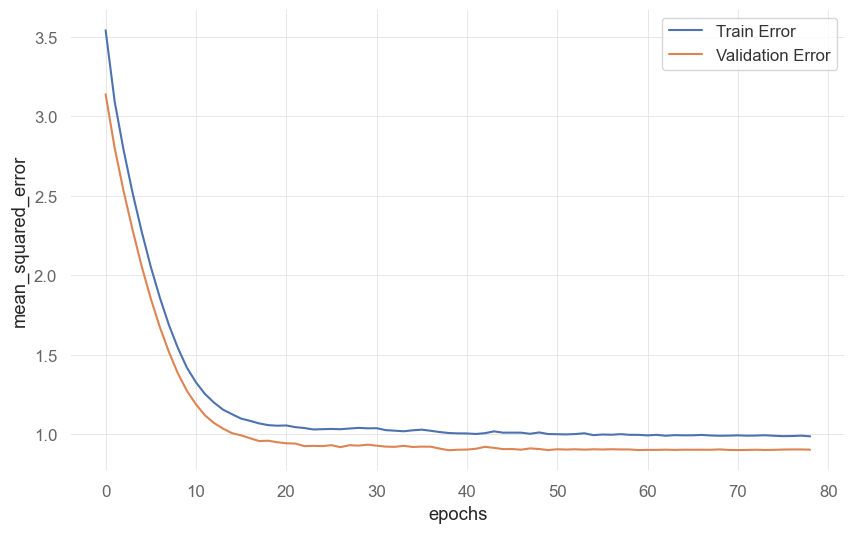

In [30]:
class LNSimpleRNNCell(layers.Layer):
    def __init__(self, units, activation="tanh", kernel_regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = layers.SimpleRNNCell(units, activation=None, kernel_regularizer=l1(0.01))
        self.layer_norm = layers.LayerNormalization()# normalise layer before activation function
        self.activation = activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]


tf.random.set_seed(42)
rnn_model = Sequential([
    layers.RNN(LNSimpleRNNCell(32), input_shape=[None,11], return_sequences=True),
    layers.Dropout(0.2),
    layers.RNN(LNSimpleRNNCell(32)),
    layers.Dense(11, activation='linear')
])

# tensorboard_cb = TensorBoard(run_logdir)

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
rnn_model.compile(optimizer='adamw', loss='mean_squared_error')
rnn_history = rnn_model.fit(X_train, y_train, epochs=150, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping_cb, reduce_lr_cb])

# %load_ext tensorboard
# %tensorboard --logdir=./my_logs

plt.plot(rnn_history.history['loss'], label='Train Error')
plt.plot(rnn_history.history['val_loss'], label='Validation Error')
plt.xlabel('epochs')
plt.ylabel('mean_squared_error')
plt.legend()

In [31]:
def create_results(train, val, test, model):
    train_pred = model.predict(train, verbose=0)
    train_pred = ss_scaler.inverse_transform(train_pred)
    train_pred = pd.DataFrame(train_pred, columns=bmk_weekly_returns.columns)

    val_pred = model.predict(val, verbose=0)
    val_pred = ss_scaler.inverse_transform(val_pred)
    val_pred = pd.DataFrame(val_pred, columns=bmk_weekly_returns.columns)

    test_pred = model.predict(test, verbose=0)
    test_pred = ss_scaler.inverse_transform(test_pred)
    test_pred = pd.DataFrame(test_pred, columns=bmk_weekly_returns.columns)

    return train_pred, val_pred, test_pred


rnn_insample, rnn_val, rnn_outsample = create_results(X_train, X_val, X_test, rnn_model)
y_acc = ss_scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_acc, rnn_outsample))
print('Test RMSE: %.3f' % rmse)

rnn_return_predictions = pd.concat([rnn_insample, rnn_val, rnn_outsample], axis=0)
rnn_return_predictions.index = bmk_weekly_returns.index[12:] 
print(rnn_return_predictions.shape)
rnn_return_predictions.head()

Test RMSE: 0.037
(1719, 11)


Industrials  Health Care  Information Technology  Utilities  \
Date                                                                      
1991-03-31     0.001202     0.002087                0.002945  -0.000669   
1991-04-07    -0.001732    -0.001059               -0.001424  -0.002537   
1991-04-14     0.001386     0.002485                0.003657  -0.000201   
1991-04-21    -0.000662     0.000287               -0.001000  -0.002516   
1991-04-28    -0.000605     0.000156               -0.000921  -0.002471   

            Financials  Materials  Consumer Discretionary  Real Estate  \
Date                                                                     
1991-03-31    0.001048  -0.000303                0.001564     0.001350   
1991-04-07   -0.002300  -0.002589               -0.000825    -0.001973   
1991-04-14    0.001707   0.000069                0.002420     0.002197   
1991-04-21   -0.000560  -0.000966                0.000551    -0.002060   
1991-04-28   -0.000665  -0.000925                0.000568    -0.002191   

            Communication Services  Consumer Staples    Energy  
Date                                                            
1991-03-31               -0.000003          0.000324  0.001661  
1991-04-07               -0.001949         -0.001051 -0.000916  
1991-04-14                0.000640          0.000542  0.001532  
1991-04-21               -0.000437         -0.000950 -0.000496  
1991-04-28               -0.000453         -0.000919 -0.000475

In [32]:
# align the index for each dataframe with the outputs
for sector in betas:
    betas[sector] = betas[sector].loc[rnn_return_predictions.index[0]:rnn_return_predictions.index[-1],:]

In [33]:
# Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
import copy

def beta_adj_returns(predictions, betas):
    beta_returns = {}
    for sector in predictions:
        # Create a deep copy of the betas for this sector
        stock_betas = copy.deepcopy(betas[sector])
        for stock in stock_betas:
            stock_betas[stock] *= predictions[sector]
        beta_returns[sector] = stock_betas
    return beta_returns


rnn_beta_returns = beta_adj_returns(rnn_return_predictions, betas)
rnn_beta_returns['Industrials'].tail()

MMM       AOS      ALLE       AAL       AME       ADP  \
Date                                                                     
2024-02-04 -0.000525 -0.000498 -0.000574 -0.001045 -0.000393 -0.000308   
2024-02-11  0.002027  0.002057  0.002494  0.004166  0.001695  0.000617   
2024-02-18 -0.000343 -0.000372 -0.000425 -0.000686 -0.000296 -0.000070   
2024-02-25 -0.000662 -0.000724 -0.000867 -0.001376 -0.000564 -0.000084   
2024-03-03 -0.000746 -0.000853 -0.000966 -0.001557 -0.000659 -0.000095   

                AXON        BA        BR      BLDR  ...      UBER       UNP  \
Date                                                ...                       
2024-02-04 -0.000544 -0.000475 -0.000351 -0.001040  ... -0.000620 -0.000478   
2024-02-11  0.002092  0.001177  0.001102  0.004096  ...  0.002238  0.001826   
2024-02-18 -0.000324 -0.000158 -0.000166 -0.000658  ... -0.000352 -0.000310   
2024-02-25 -0.000674 -0.000322 -0.000336 -0.001120  ... -0.000820 -0.000584   
2024-03-03 -0.000825 -0.000364 -0.000440 -0.001301  ... -0.001150 -0.000697   

                 UAL       UPS       URI      VRSK       WAB        WM  \
Date                                                                     
2024-02-04 -0.000938 -0.000498 -0.001087 -0.000134 -0.000401 -0.000179   
2024-02-11  0.003379  0.001846  0.004433  0.000332  0.001430  0.000703   
2024-02-18 -0.000540 -0.000343 -0.000702 -0.000061 -0.000225 -0.000116   
2024-02-25 -0.001101 -0.000646 -0.001459 -0.000157 -0.000405 -0.000124   
2024-03-03 -0.001244 -0.000709 -0.001687 -0.000182 -0.000444 -0.000106   

                 GWW       XYL  
Date                            
2024-02-04 -0.000435 -0.000467  
2024-02-11  0.001766  0.001824  
2024-02-18 -0.000332 -0.000344  
2024-02-25 -0.000678 -0.000697  
2024-03-03 -0.000782 -0.000818  

[5 rows x 77 columns]

In [34]:
def test_model(return_predictions, returns_dataframe, rebal_period):
    _, num_securities_held, momentum_selection, _ = rank_momentum_signal(signal_dict=return_predictions, returns_dict=returns_dataframe, 
                                                                        dict=True, ls_skew = [0.2, 0.1], regime_df=regime)
    
    # Portolfio Construction - Equally Weighted
    portfolio = portfolio_weighting_scheme(weight_scheme='equal_weight', portfolio_selections=momentum_selection,
                                            securities_per_sector=num_securities_held, dict=True, rebal_period=rebal_period, 
                                            regime=False, regime_df=regime)
    portfolio['Strategy'] = (((1+portfolio).prod(axis=1)-1) / num_sectors)
    portfolio = add_transaction_costs(survivorship_bias = True, rebalance_freq = rebal_period,
                                        dataframe = portfolio, target_costs = 0.03)
    
    return portfolio, momentum_selection


# Calculating the returns for the strategy
rnn_portfolio, selected_stocks = test_model(rnn_beta_returns, sector_returns, rebal_period=rebal_period)
rnn_portfolio.tail(3)

Industrials Health Care Information Technology Utilities  \
Date                                                                  
2024-02-18     0.00837    0.010801                0.02103 -0.014466   
2024-02-25    0.001114    0.000236               0.018882   0.01031   
2024-03-03   -0.003526   -0.000488               -0.00972   0.00168   

           Financials Materials Consumer Discretionary Real Estate  \
Date                                                                 
2024-02-18   0.006837  0.000892               -0.00368   -0.010124   
2024-02-25   0.013056  0.024849              -0.012236    0.012153   
2024-03-03   0.003721  0.000585              -0.009969   -0.001552   

           Communication Services Consumer Staples    Energy  Strategy  
Date                                                                    
2024-02-18              -0.003558        -0.003675  0.004108  0.001492  
2024-02-25               0.031864         0.004968  -0.01357  0.008696  
2024-03-03              -0.004663         0.002519  -0.00127 -0.002068

Testing performance - all strategy returns that follow will only display out-of-sample performance

[*********************100%%**********************]  2 of 2 completed


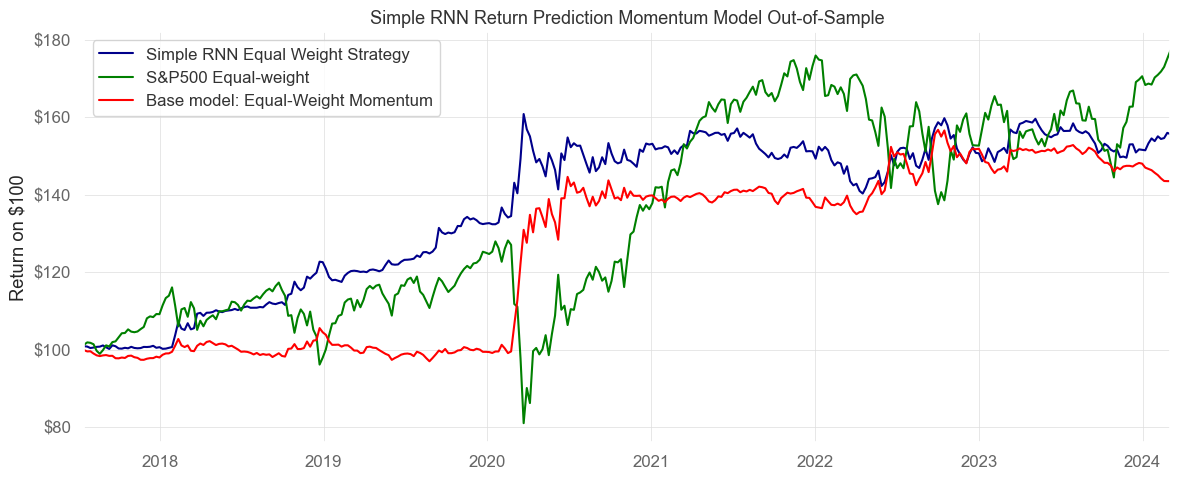

In [35]:
bmks = yf.download(['^SPX','RSP'], period='max', interval='1d').Close.resample(rebal_period).last()
bmks = pd.DataFrame(bmks.pct_change())
bmks.index = pd.to_datetime(bmks.index)

# Growth of $100 for the RNN strategy versus the base models and benchmark
rnn_strategy = (1+rnn_portfolio['Strategy'].iloc[int(len(rnn_portfolio.index)*0.8):]).cumprod() * 100
bmk = (1+bmks['RSP'].loc[rnn_strategy.index[0]:rnn_strategy.index[-1]]).cumprod() * 100
ew_null = (1+sector_split_portfolios['Portfolio'].loc[rnn_strategy.index[0]:rnn_strategy.index[-1]]).cumprod() * 100

fig, ax = plt.subplots(figsize=(12,5), sharex=True)
ax.plot(rnn_strategy, label="Simple RNN Equal Weight Strategy", color="darkblue")
ax.plot(bmk, label="S&P500 Equal-weight", color="green")
ax.plot(ew_null, label="Base model: Equal-Weight Momentum", color="red")

ax.set_title('Simple RNN Return Prediction Momentum Model Out-of-Sample',fontsize=13)
ax.set_ylabel('Return on $100')
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(min(rnn_strategy.index),max(rnn_strategy.index))
ax.legend(loc=0)
plt.tight_layout()

## Tuning the neural network

### Finding the best lookback - only using in-sample period

In [210]:
rnn_results = {'sharpe': [], 'max_drawdown': [], 'total_return': []}
num_simulations = 10
for j, lookback in enumerate([1, 2, 3, 4]):
    
    # Splitting into trian, validation and test sets
    num_stocks = bmk_weekly_returns.shape[1]
    n = bmk_weekly_returns.shape[0]
    idx_train = int(0.7 * n)
    idx_val = int(0.85 * n)        
    X_train, X_val, X_test = bmk_weekly_returns.iloc[:idx_train, :], bmk_weekly_returns.iloc[idx_train:idx_val, :], bmk_weekly_returns.iloc[idx_val:, :]

    # Scaling the data
    ss_scaler = StandardScaler()
    X_train = ss_scaler.fit_transform(X_train)
    X_val = ss_scaler.transform(X_val)
    X_test = ss_scaler.transform(X_test)

    X_train, y_train = create_multivariate_rnn_data(X_train, lookback)
    X_val, y_val = create_multivariate_rnn_data(X_val, lookback)
    X_test, y_test = create_multivariate_rnn_data(X_test, lookback)

    sharpe = []
    max_drawdown = []
    total_return = []
    for i in range(num_simulations):
  
        tf.keras.backend.clear_session()
        rnn_model = Sequential([
            layers.RNN(LNSimpleRNNCell(32), input_shape=[None,11], return_sequences=True),
            layers.Dropout(0.2),
            layers.RNN(LNSimpleRNNCell(32)),
            layers.Dense(11, activation='linear')
        ])
        
        tf.random.set_seed(42)
        early_stopping_cb = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
        reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=0)
        rnn_model.compile(optimizer='adamw', loss='mean_squared_error')
        rnn_history = rnn_model.fit(X_train, y_train, epochs=150, verbose=0, validation_data=(X_val, y_val), 
                                    callbacks=[early_stopping_cb, reduce_lr_cb]) # callbacks=[tensorboard_cb]
        
        # rnn_insample, rnn_val, rnn_outsample = create_results(X_train, X_val, X_test, rnn_model)
        rnn_insample = rnn_model.predict(X_train, verbose=0)
        rnn_insample = ss_scaler.inverse_transform(rnn_insample)
        rnn_insample = pd.DataFrame(rnn_insample, columns=bmk_weekly_returns.columns)

        rnn_val = rnn_model.predict(X_val, verbose=0)
        rnn_val = ss_scaler.inverse_transform(rnn_val)
        rnn_val = pd.DataFrame(rnn_val, columns=bmk_weekly_returns.columns)
        
        # Excluding test set to ensure no data leakage
        rnn_return_predictions = pd.concat([rnn_insample, rnn_val], axis=0)
        if j == 0:
            rnn_return_predictions.index = bmk_weekly_returns.index[3:-259]
        elif j == 1:
            rnn_return_predictions.index = bmk_weekly_returns.index[6:-258]
        elif j == 2:
            rnn_return_predictions.index = bmk_weekly_returns.index[9:-257]
        elif j == 3:
            rnn_return_predictions.index = bmk_weekly_returns.index[12:-256]
        elif j == 4:
            rnn_return_predictions.index = bmk_weekly_returns.index[24:-260]
        else:
            rnn_return_predictions.index = bmk_weekly_returns.index[36:-256]

        # Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
        beta_returns_prediction = {}
        for sector in rnn_return_predictions:
            # Create a deep copy of the betas for this sector
            stock_betas = copy.deepcopy(betas[sector].loc[rnn_return_predictions.index[0]:rnn_return_predictions.index[-1],:])
            for stock in stock_betas:
                stock_betas[stock] *= rnn_return_predictions[sector]
            beta_returns_prediction[sector] = stock_betas

        rnn_portfolio, selected_stocks = test_model(beta_returns_prediction, sector_returns, rebal_period=rebal_period)
        rnn_strategy = (1+rnn_portfolio['Strategy'].iloc[int(len(rnn_portfolio.index)*0.8):]).cumprod() * 100
        sharpe.append(qs.stats.sharpe(rnn_strategy, rf=0.03))
        max_drawdown.append(qs.stats.max_drawdown(rnn_strategy))
        total_return.append(rnn_strategy[-1])

    rnn_results['sharpe'].append(np.mean(sharpe))
    rnn_results['max_drawdown'].append(np.mean(max_drawdown))
    rnn_results['total_return'].append(np.mean(total_return))
    print(f'Lookback {lookback} complete.')

Lookback 1 complete.
Lookback 2 complete.
Lookback 3 complete.
Lookback 4 complete.


Results over 10 runs per lookback for 1/2/3/4/8/12 weeks 
- 'sharpe': [1.4695762700830364,1.3978079116590236,1.8051639611299521,1.8515322022957705,1.839957694839951,  1.7144105653062993],
- 'max_drawdown': [-0.12923431033380678,-0.1397181438679463,-0.09931362779132942,-0.11223866808742522,-0.13384318704319909,  -0.10857896679386383]
- 'total_return': [162.57571042377447,157.29132948577606,167.1894595774466,185.84233337236535,179.9732416059163,  170.03647254455865],
- 'RMSE': [0.03685798163434808,0.036915481247215866,0.03713802202700031,0.03707507378941825,0.037662983718159834,0.0377778703090103]}

### Hyperparameter tuning the base model for neurons and L1 regularisation - only using in-sample period

In [ ]:
# 100 runs
num_simulations = 20
units = [8, 16, 32, 64]
l1_reg = [0.01, 0.1, 1.0]
av_results = {'sharpe': pd.DataFrame(index=units), 'max_drawdown': pd.DataFrame(index=units), 
              'total_return': pd.DataFrame(index=units), 'RMSE': pd.DataFrame(index=units)}

for param in l1_reg:
    row_iter = 0
    for n in units:
        av_results['sharpe'][f'{n}_units_{param}_reg'] = 0
        av_results['max_drawdown'][f'{n}_units_{param}_reg'] = 0
        av_results['total_return'][f'{n}_units_{param}_reg'] = 0
        av_results['RMSE'][f'{n}_units_{param}_reg'] = 0
        rnn_results = {'sharpe': [], 'max_drawdown': [], 'total_return': [], 'RMSE': []}

        for i in range(num_simulations):

            tf.keras.backend.clear_session()
            tf.random.set_seed(42)
            rnn_model = Sequential([
                layers.RNN(LNSimpleRNNCell(32), input_shape=[None,11], return_sequences=True),
                layers.Dropout(0.2),
                layers.RNN(LNSimpleRNNCell(32)),
                layers.Dense(11, activation='linear')
            ])
            
            tf.random.set_seed(42)
            early_stopping_cb = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
            reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=0)
            rnn_model.compile(optimizer='adamw', loss='mean_squared_error')
            rnn_history = rnn_model.fit(X_train, y_train, epochs=150, verbose=0, validation_data=(X_val, y_val), 
                                        callbacks=[early_stopping_cb, reduce_lr_cb]) # callbacks=[tensorboard_cb]
            
            # rnn_insample, rnn_val, rnn_outsample = create_results(X_train, X_val, X_test, rnn_model)
            rnn_insample = rnn_model.predict(X_train, verbose=0)
            rnn_insample = ss_scaler.inverse_transform(rnn_insample)
            rnn_insample = pd.DataFrame(rnn_insample, columns=bmk_weekly_returns.columns)

            rnn_val = rnn_model.predict(X_val, verbose=0)
            rnn_val = ss_scaler.inverse_transform(rnn_val)
            rnn_val = pd.DataFrame(rnn_val, columns=bmk_weekly_returns.columns)

            y_acc = ss_scaler.inverse_transform(y_val)
            rnn_results['RMSE'].append(np.sqrt(mean_squared_error(y_acc, rnn_val)))

            rnn_return_predictions = pd.concat([rnn_insample, rnn_val], axis=0)

            # Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
            beta_returns_prediction = {}
            for sector in rnn_return_predictions:
                # Create a deep copy of the betas for this sector
                stock_betas = copy.deepcopy(betas[sector].loc[rnn_return_predictions.index[0]:rnn_return_predictions.index[-1],:])
                for stock in stock_betas:
                    stock_betas[stock] *= rnn_return_predictions[sector]
                beta_returns_prediction[sector] = stock_betas

            rnn_portfolio, selected_stocks = test_model(beta_returns_prediction, sector_returns, rebal_period=rebal_period)
            rnn_strategy = (1+rnn_portfolio['Strategy'].iloc[int(len(rnn_portfolio.index)*0.8):]).cumprod() * 100
            sharpe.append(qs.stats.sharpe(rnn_strategy, rf=0.03))
            max_drawdown.append(qs.stats.max_drawdown(rnn_strategy))
            total_return.append(rnn_strategy[-1])

            rnn_results['sharpe'].append(np.mean(sharpe))
            rnn_results['max_drawdown'].append(np.mean(max_drawdown))
            rnn_results['total_return'].append(np.mean(total_return))

        av_results['sharpe'][f'{n}_units_{param}_reg'].iloc[row_iter] = (np.mean(rnn_results['sharpe']))
        av_results['max_drawdown'][f'{n}_units_{param}_reg'].iloc[row_iter] = (np.mean(rnn_results['max_drawdown']))
        av_results['total_return'][f'{n}_units_{param}_reg'].iloc[row_iter] = ((np.mean(rnn_results['total_return'])-100)/100)
        av_results['RMSE'][f'{n}_units_{param}_reg'].iloc[row_iter] = (np.mean(rnn_results['RMSE']))
        row_iter += 1

A 4-week lookback shows significant outperformance, so it will be used going forward. L1=0.01 and Neurons = 23 are chosen, although there isnt much difference between these parameters and performance.

In [36]:
# Splitting into trian, validation and test sets
lookback = 4
num_stocks = bmk_weekly_returns.shape[1]
n = bmk_weekly_returns.shape[0]
idx_train = int(0.7 * n)
idx_val = int(0.85 * n)        
X_train, X_val, X_test = bmk_weekly_returns.iloc[:idx_train, :], bmk_weekly_returns.iloc[idx_train:idx_val, :], bmk_weekly_returns.iloc[idx_val:, :]

# Scaling the data
ss_scaler = StandardScaler()
X_train = ss_scaler.fit_transform(X_train)
X_val = ss_scaler.transform(X_val)
X_test = ss_scaler.transform(X_test)

X_train, y_train = create_multivariate_rnn_data(X_train, lookback)
X_val, y_val = create_multivariate_rnn_data(X_val, lookback)
X_test, y_test = create_multivariate_rnn_data(X_test, lookback)

In [ ]:
# 100 runs
rnn_results = {'sharpe': [], 'max_drawdown': [], 'total_return': [], 'RMSE': []}
num_simulations = 100
for i in range(num_simulations):
    
    tf.keras.backend.clear_session()
    rnn_model = Sequential([
            layers.RNN(LNSimpleRNNCell(32), input_shape=[None,11], return_sequences=True),
            layers.Dropout(0.2),
            layers.RNN(LNSimpleRNNCell(32)),
            layers.Dense(11, activation='linear')
        ])
    tf.random.set_seed(42)

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=0)
    rnn_model.compile(optimizer='adamw', loss='mean_squared_error')
    rnn_history = rnn_model.fit(X_train, y_train, epochs=150, verbose=0, validation_data=(X_val, y_val), 
                                callbacks=[early_stopping_cb, reduce_lr_cb]) # callbacks=[tensorboard_cb]
    
    rnn_insample, rnn_val, rnn_outsample = create_results(X_train, X_val, X_test, rnn_model)
    y_acc = ss_scaler.inverse_transform(y_test)
    rnn_results['RMSE'].append(np.sqrt(mean_squared_error(y_acc, rnn_outsample)))
    
    rnn_return_predictions = pd.concat([rnn_insample, rnn_val, rnn_outsample], axis=0)
    rnn_return_predictions.index = bmk_weekly_returns.index[12:]

    # Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
    betas, sector_benchmarks = calculate_rolling_beta(prices, window_size=60, resample=rebal_period)
    rnn_beta_returns = beta_adj_returns(rnn_return_predictions, betas)

    rnn_portfolio, selected_stocks = test_model(rnn_beta_returns, sector_returns, rebal_period=rebal_period)
    rnn_strategy = (1+rnn_portfolio['Strategy'].iloc[int(len(rnn_portfolio.index)*0.8):]).cumprod() * 100
    rnn_results['sharpe'].append(qs.stats.sharpe(rnn_strategy, rf=0.03))
    rnn_results['max_drawdown'].append(qs.stats.max_drawdown(rnn_strategy))
    rnn_results['total_return'].append(rnn_strategy[-1])
    if i % 10 == 0:
        print(f'Run {i} complete.')

Run 0 done.
Run 1 done.
Run 2 done.
Run 3 done.
Run 4 done.
Run 5 done.
Run 6 done.
Run 7 done.
Run 8 done.
Run 9 done.
Run 10 done.
Run 11 done.
Run 12 done.
Run 13 done.
Run 14 done.
Run 15 done.
Run 16 done.
Run 17 done.
Run 18 done.
Run 19 done.
Run 20 done.
Run 21 done.
Run 22 done.
Run 23 done.
Run 24 done.
Run 25 done.
Run 26 done.
Run 27 done.
Run 28 done.
Run 29 done.
Run 30 done.
Run 31 done.
Run 32 done.
Run 33 done.
Run 34 done.
Run 35 done.
Run 36 done.
Run 37 done.
Run 38 done.
Run 39 done.
Run 40 done.
Run 41 done.
Run 42 done.
Run 43 done.
Run 44 done.
Run 45 done.
Run 46 done.
Run 47 done.
Run 48 done.
Run 49 done.
Run 50 done.
Run 51 done.
Run 52 done.
Run 53 done.
Run 54 done.
Run 55 done.
Run 56 done.
Run 57 done.
Run 58 done.
Run 59 done.
Run 60 done.
Run 61 done.
Run 62 done.
Run 63 done.
Run 64 done.
Run 65 done.
Run 66 done.
Run 67 done.
Run 68 done.
Run 69 done.
Run 70 done.
Run 71 done.
Run 72 done.
Run 73 done.
Run 74 done.
Run 75 done.
Run 76 done.
Run 77 do

In [ ]:
# save the dictory to csv
rnn_portfolio.to_csv('rnn_sector_results.csv', index=True)

### Benchmark prediction using LSTM


Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


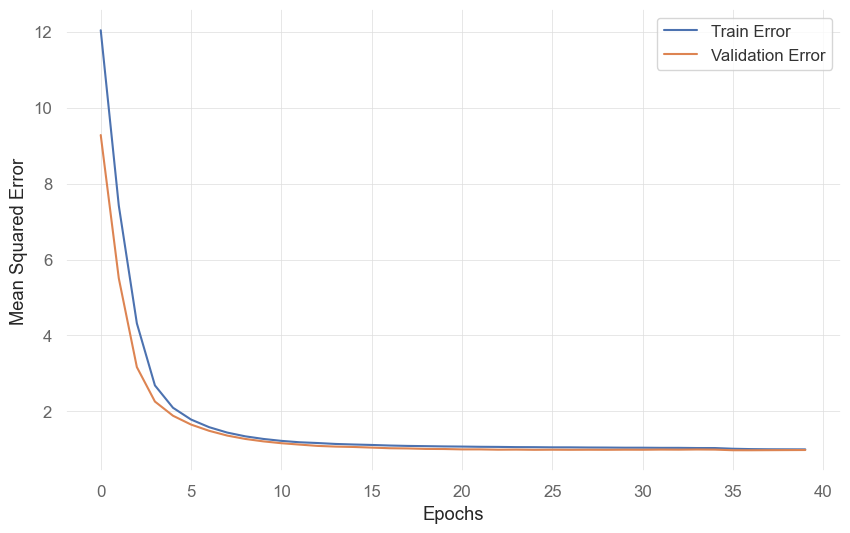

In [37]:
# Building the LSTM Model class with the same inputs at RNN for comparison
class LNLSTMCell(layers.Layer):
    def __init__(self, units, activation="tanh", kernel_regularizer=None, recurrent_dropout=0.2, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        # LSTMCell now properly initialized
        self.lstm_cell = layers.LSTMCell(units, activation=activation, recurrent_dropout=recurrent_dropout, kernel_regularizer=l1(0.01))
        self.layer_norm = layers.LayerNormalization()
        self.activation_fn = activations.get(activation)
        
        # Define state_size for LSTM cell (hidden state h and cell state c)
        self.state_size = [self.units, self.units]  # Tuple of two elements for LSTM's hidden and cell states
        self.output_size = self.units

    def call(self, inputs, states):
        # LSTMCell processes inputs and states
        outputs, new_states = self.lstm_cell(inputs, states=states)
        norm_outputs = self.layer_norm(outputs)
        activated_outputs = self.activation_fn(norm_outputs)
        return activated_outputs, new_states

class LNLSTMModel(Model):
    def __init__(self, units, input_shape, output_size):
        super().__init__()
        self.rnn1 = layers.RNN(LNLSTMCell(units, recurrent_dropout=0.2), return_sequences=True, input_shape=input_shape)
        # RegularizedDense = partial(LSTM, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), dropout=0.2, 
        # recurrent_activation="sigmoid", recurrent_dropout=0.1, return_sequences=True)
        self.dropout = layers.Dropout(0.2)
        self.rnn2 = layers.RNN(LNLSTMCell(units, recurrent_dropout=0.2))
        self.dense = layers.Dense(output_size, activation='linear')
        
    def call(self, inputs):
        x = self.rnn1(inputs)
        x = self.dropout(x)
        x = self.rnn2(x)
        return self.dense(x)

tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Instantiate, compile and fit the model
lstm_model = LNLSTMModel(units=64, input_shape=(4, 11), output_size=11) 
lstm_model.compile(optimizer='adamw', loss='mean_squared_error')
lstm_history = lstm_model.fit(X_train, y_train, epochs=150, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping_cb, reduce_lr_cb])

# Plot training history
plt.plot(lstm_history.history['loss'], label='Train Error')
plt.plot(lstm_history.history['val_loss'], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [38]:
lstm_insample, lstm_val, lstm_outsample = create_results(X_train, X_val, X_test, lstm_model)
rmse = np.sqrt(mean_squared_error(y_acc, lstm_outsample))
print('Test RMSE: %.3f' % rmse)

lstm_return_predictions = pd.concat([lstm_insample, lstm_val, lstm_outsample], axis=0)
lstm_return_predictions.index = bmk_weekly_returns.index[12:]
print(lstm_return_predictions.shape)
lstm_return_predictions.head()

Test RMSE: 0.038
(1719, 11)


Industrials  Health Care  Information Technology  Utilities  \
Date                                                                      
1991-03-31     0.006895    -0.006920                0.008850   0.000394   
1991-04-07     0.006505    -0.001717                0.030554  -0.001289   
1991-04-14    -0.012634     0.003912                0.001586  -0.002838   
1991-04-21    -0.009981     0.004112               -0.008275  -0.005915   
1991-04-28    -0.007349     0.004142               -0.006189  -0.005812   

            Financials  Materials  Consumer Discretionary  Real Estate  \
Date                                                                     
1991-03-31    0.009454   0.006749                0.010159    -0.006956   
1991-04-07    0.011652   0.001311                0.004875    -0.000230   
1991-04-14   -0.006663  -0.006435               -0.008584    -0.004292   
1991-04-21   -0.008695  -0.007295               -0.004841     0.005219   
1991-04-28   -0.006697  -0.009427               -0.005854     0.005753   

            Communication Services  Consumer Staples    Energy  
Date                                                            
1991-03-31                0.003660          0.002994 -0.006281  
1991-04-07               -0.000558          0.007374 -0.000196  
1991-04-14               -0.004731          0.000036  0.013588  
1991-04-21               -0.002935          0.000318  0.006180  
1991-04-28               -0.003486          0.001682  0.005289

In [39]:
# Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
lstm_beta_returns = beta_adj_returns(lstm_return_predictions, betas)

# Calculating the returns for the strategy and testing it vs benchmarks
lstm_portfolio, selected_stocks = test_model(lstm_beta_returns, sector_returns, rebal_period=rebal_period)

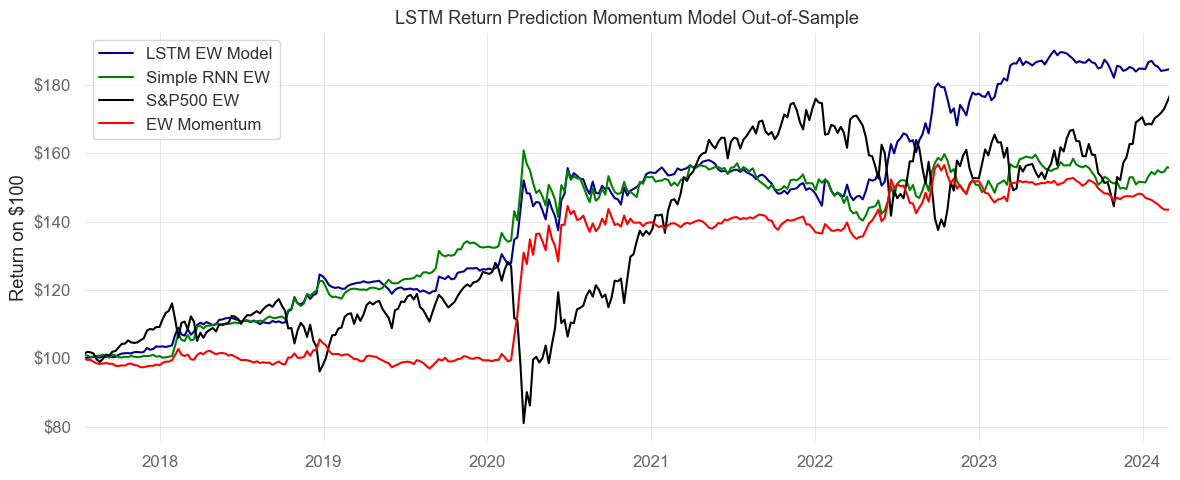

In [40]:
lstm_strategy = (1+lstm_portfolio['Strategy'].iloc[int(len(lstm_portfolio.index)*0.8):]).cumprod() * 100
bmk = (1+bmks['RSP'].loc[lstm_strategy.index[0]:lstm_strategy.index[-1]]).cumprod() * 100
ew_null = (1+sector_split_portfolios['Portfolio'].loc[lstm_strategy.index[0]:lstm_strategy.index[-1]]).cumprod() * 100

fig, ax = plt.subplots(figsize=(12,5), sharex=True)
ax.plot(lstm_strategy, label="LSTM EW Model", color="darkblue")
ax.plot(rnn_strategy, label="Simple RNN EW", color="green")
ax.plot(bmk, label="S&P500 EW", color="black")
ax.plot(ew_null, label="EW Momentum", color="red")

ax.set_title('LSTM Return Prediction Momentum Model Out-of-Sample',fontsize=13)
ax.set_ylabel('Return on $100')
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(min(lstm_strategy.index),max(lstm_strategy.index))
ax.legend(loc=0)
plt.tight_layout()

In [41]:
# 100 runs
lstm_results = {'sharpe': [], 'max_drawdown': [], 'total_return': [], 'RMSE': []}
num_simulations = 100
for i in range(num_simulations):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=0)
    lstm_model = LNLSTMModel(units=64, input_shape=(4, 11), output_size=11) 
    lstm_model.compile(optimizer='adamw', loss='mean_squared_error')
    lstm_history = lstm_model.fit(X_train, y_train, epochs=150, verbose=0, validation_data=(X_val, y_val), 
                                  callbacks=[early_stopping_cb, reduce_lr_cb])

    lstm_insample, lstm_val, lstm_outsample = create_results(X_train, X_val, X_test, lstm_model)
    lstm_results['RMSE'].append(np.sqrt(mean_squared_error(y_acc, lstm_outsample)))

    lstm_return_predictions = pd.concat([lstm_insample, lstm_val, lstm_outsample], axis=0)
    lstm_return_predictions.index = bmk_weekly_returns.index[12:]

    # Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
    betas, sector_benchmarks = calculate_rolling_beta(prices, window_size=60, resample=rebal_period)
    beta_returns_prediction = beta_adj_returns(lstm_return_predictions, betas)

    lstm_portfolio, selected_stocks = test_model(beta_returns_prediction, sector_returns, rebal_period=rebal_period)
    lstm_strategy = (1+lstm_portfolio['Strategy'].iloc[int(len(lstm_portfolio.index)*0.8):]).cumprod() * 100
    lstm_results['sharpe'].append(qs.stats.sharpe(lstm_strategy, rf=0.03))
    lstm_results['max_drawdown'].append(qs.stats.max_drawdown(lstm_strategy))
    lstm_results['total_return'].append(lstm_strategy[-1])
    if i % 10 == 0:
        print(f'Simulation {i} complete.')  

Simulation 0 complete.
Simulation 10 complete.
Simulation 20 complete.
Simulation 30 complete.
Simulation 40 complete.
Simulation 50 complete.
Simulation 60 complete.
Simulation 70 complete.
Simulation 80 complete.
Simulation 90 complete.


In [44]:
np.mean(lstm_results['sharpe']), np.mean(lstm_results['max_drawdown']), np.mean(lstm_results['total_return']), np.mean(lstm_results['RMSE'])

(1.877271687942285,
 -0.1373338535315303,
 185.81758757562818,
 0.037148538362730174)

In [ ]:
lstm_portfolio.to_csv('lstm_sector_results.csv', index=True)

## Adding a Regime layer to LSTM Benchmark based model

In [42]:
# Splitting into trian, validation and test sets
num_stocks = bmk_weekly_returns.shape[1]
n = bmk_weekly_returns.shape[0]
idx_train = int(0.7 * n)
idx_val = int(0.85 * n)        
X_train, X_val, X_test = bmk_weekly_returns.iloc[:idx_train, :], bmk_weekly_returns.iloc[idx_train:idx_val, :], bmk_weekly_returns.iloc[idx_val:, :]

# Scaling the data
ss_scaler = StandardScaler()
X_train = ss_scaler.fit_transform(X_train)
X_val = ss_scaler.transform(X_val)
X_test = ss_scaler.transform(X_test)

X_train, y_train = create_multivariate_rnn_data(X_train, 4)
X_val, y_val = create_multivariate_rnn_data(X_val, 4)
X_test, y_test = create_multivariate_rnn_data(X_test, 4)


# Incorporting HMM regime into the model
regime_input = pd.read_csv('1_hidden_states.csv', index_col='Date')
regime_input.index = pd.to_datetime(regime_input.index)
regime_input = regime_input.resample(rebal_period).last()
regime_input = regime_input.loc[bmk_weekly_returns.index[0]:bmk_weekly_returns.index[-1],:].values
regime_input = np.tile(regime_input, (1, 11))
regime_train = regime_input[:int(0.7*len(regime_input)),:]
regime_val = regime_input[int(0.7*len(regime_input)):int(0.85*len(regime_input)),:]
regime_test = regime_input[int(0.85*len(regime_input)):,:]

def align_regime_data(data, window_size):
    n = data.shape[0]
    X = np.stack([data[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return X

# seperating the regime data into the same format
X_train_regime = align_regime_data(regime_train, 4)
X_val_regime = align_regime_data(regime_val, 4)
X_test_regime = align_regime_data(regime_test, 4)
X_train_regime.shape, X_val_regime.shape, X_test_regime.shape

((1207, 4, 11), (256, 4, 11), (256, 4, 11))

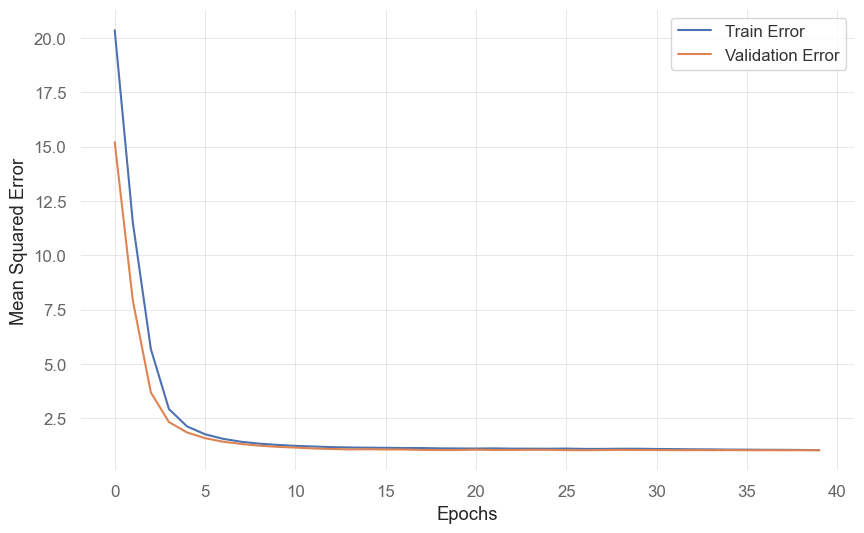

In [43]:
# Building the LSTM Model class adding in a regime layer
class LNLSTMCell_regime(layers.Layer):
    def __init__(self, units, activation="tanh", kernel_regularizer=None, recurrent_dropout=0.2, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        # LSTMCell now properly initialized
        self.lstm_cell = layers.LSTMCell(units, activation=activation, recurrent_dropout=recurrent_dropout, kernel_regularizer=l1(0.01))
        self.layer_norm = layers.LayerNormalization()
        self.activation_fn = activations.get(activation)
        
        # Define state_size for LSTM cell (hidden state h and cell state c)
        self.state_size = [self.units, self.units]  # Tuple of two elements for LSTM's hidden and cell states
        self.output_size = self.units

    def call(self, inputs, states):
        # LSTMCell processes inputs and states
        outputs, new_states = self.lstm_cell(inputs, states=states)
        norm_outputs = self.layer_norm(outputs)
        activated_outputs = self.activation_fn(norm_outputs)
        return activated_outputs, new_states

class LNLSTMModel_Regime(Model):
    def __init__(self, units, input_shape_stock, input_shape_regime, output_size):
        super().__init__()
        # Assuming input_shape_stock and input_shape_regime are correctly provided
        self.regime_dense = layers.Dense(units, activation="tanh")  # Process regime data
        # Adjust for the combined input shape after concatenation
        combined_input_shape = (input_shape_stock[0], input_shape_stock[1] + input_shape_regime[1])
        self.rnn1 = layers.RNN(LNLSTMCell_regime(units, recurrent_dropout=0.2), return_sequences=True, input_shape=combined_input_shape)
        self.dropout = layers.Dropout(0.2)
        self.rnn2 = layers.RNN(LNLSTMCell_regime(units, recurrent_dropout=0.2))
        self.dense = layers.Dense(output_size, activation='linear')
        
    def call(self, inputs):
        stock_input, regime_input = inputs
        # Assuming regime_input is expanded to match the stock_input's last dimension if needed
        regime_processed = self.regime_dense(regime_input)
        # Note: The Concatenate layer is functional and needs to be instantiated
        combined_input = layers.Concatenate(axis=-1)([stock_input, regime_processed])
        x = self.rnn1(combined_input)
        x = self.dropout(x)
        x = self.rnn2(x)
        return self.dense(x)
    

# Instantiate the model
tf.keras.backend.clear_session()
tf.random.set_seed(42)
regime_lstm_model = LNLSTMModel_Regime(units=32, input_shape_stock=(None, 4, 11), input_shape_regime=(None, 4, 11), output_size=11)
regime_lstm_model.compile(optimizer='adamw', loss='mean_squared_error')
regime_lstm_history = regime_lstm_model.fit([X_train, X_train_regime], y_train, epochs=150, verbose=0, 
                                            validation_data=([X_val, X_val_regime], y_val), callbacks=[early_stopping_cb])

# Plot training history
plt.plot(regime_lstm_history.history['loss'], label='Train Error')
plt.plot(regime_lstm_history.history['val_loss'], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

In [ ]:
def create_regime_results(train, val, test, regime_train, regime_val, regime_test, model):
    train_pred = model.predict([train,regime_train], verbose=0)
    train_pred = ss_scaler.inverse_transform(train_pred)
    train_pred = pd.DataFrame(train_pred, columns=bmk_weekly_returns.columns)

    val_pred = model.predict([val, regime_val], verbose=0)
    val_pred = ss_scaler.inverse_transform(val_pred)
    val_pred = pd.DataFrame(val_pred, columns=bmk_weekly_returns.columns)

    test_pred = model.predict([test, regime_test], verbose=0)
    test_pred = ss_scaler.inverse_transform(test_pred)
    test_pred = pd.DataFrame(test_pred, columns=bmk_weekly_returns.columns)

    return train_pred, val_pred, test_pred

regime_lstm_insample, regime_lstm_val, regime_lstm_outsample = create_regime_results(X_train, X_val, X_test, 
                                                                                     X_train_regime, X_val_regime, 
                                                                                     X_test_regime, regime_lstm_model)
y_acc = ss_scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_acc, regime_lstm_outsample))
print('Test RMSE: %.3f' % rmse)

lstm_regime_predictions = pd.concat([regime_lstm_insample, regime_lstm_val, regime_lstm_outsample], axis=0)
lstm_regime_predictions.index = bmk_weekly_returns.index[12:]
print(lstm_regime_predictions.shape)
lstm_regime_predictions.head()

Test RMSE: 0.038
(1719, 11)


Industrials  Health Care  Information Technology  Utilities  \
Date                                                                      
1991-03-31    -0.013529     0.005105                0.007312   0.000329   
1991-04-07    -0.012757     0.005678               -0.010959  -0.004247   
1991-04-14    -0.009943    -0.000790               -0.010715  -0.001570   
1991-04-21    -0.011379    -0.002839               -0.006334  -0.002317   
1991-04-28    -0.009647    -0.003959               -0.001327  -0.002552   

            Financials  Materials  Consumer Discretionary  Real Estate  \
Date                                                                     
1991-03-31    0.005415  -0.004870                0.007789    -0.014082   
1991-04-07    0.001970   0.001433               -0.003444    -0.033186   
1991-04-14   -0.005175   0.003582               -0.005040    -0.016037   
1991-04-21   -0.003031  -0.002738               -0.000835    -0.013115   
1991-04-28   -0.001673  -0.003860               -0.003966    -0.014794   

            Communication Services  Consumer Staples    Energy  
Date                                                            
1991-03-31               -0.004600         -0.003144  0.012477  
1991-04-07               -0.009752          0.004867  0.011007  
1991-04-14               -0.000721          0.001832 -0.006215  
1991-04-21               -0.003218          0.002695 -0.009331  
1991-04-28               -0.002143          0.001977 -0.000676

In [ ]:
# Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
regime_lstm_beta_returns = beta_adj_returns(lstm_regime_predictions, betas)

# Calculating the returns for the strategy and testing it vs benchmarks
regime_lstm_portfolio, selected_stocks = test_model(regime_lstm_beta_returns, sector_returns, rebal_period=rebal_period)

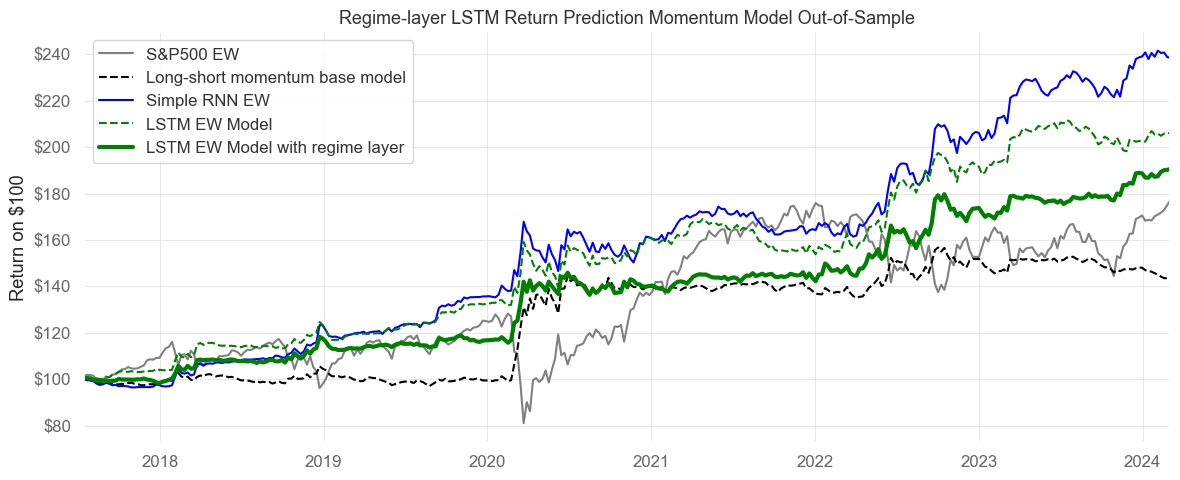

In [ ]:
regime_lstm_strategy = (1+regime_lstm_portfolio['Strategy'].iloc[int(len(regime_lstm_portfolio.index)*0.8):]).cumprod() * 100
bmk = (1+bmks['RSP'].loc[regime_lstm_strategy.index[0]:regime_lstm_strategy.index[-1]]).cumprod() * 100
ew_null = (1+sector_split_portfolios['Portfolio'].loc[regime_lstm_strategy.index[0]:regime_lstm_strategy.index[-1]]).cumprod() * 100

fig, ax = plt.subplots(figsize=(12,5), sharex=True)
ax.plot(bmk, label="S&P500 EW", color="grey")
ax.plot(ew_null, label="Long-short momentum base model", color="black", ls='dashed')
ax.plot(rnn_strategy, label="Simple RNN EW", color="blue")
ax.plot(lstm_strategy, label="LSTM EW Model", color="green", ls='dashed')
ax.plot(regime_lstm_strategy, label="LSTM EW Model with regime layer", color="green", linewidth=3)

ax.set_title('Regime-layer LSTM Return Prediction Momentum Model Out-of-Sample',fontsize=13)
ax.set_ylabel('Return on $100')
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(min(regime_lstm_strategy.index),max(regime_lstm_strategy.index))
ax.legend(loc=0)
plt.tight_layout()

In [ ]:
# 100 runs
regime_lstm_results = {'sharpe': [], 'max_drawdown': [], 'total_return': [], 'RMSE': []}
num_simulations = 100
for i in range(num_simulations):

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=0)
    regime_lstm_model = LNLSTMModel_Regime(units=32, input_shape_stock=(None, 4, 11), input_shape_regime=(None, 4, 11), output_size=11)
    regime_lstm_model.compile(optimizer='adamw', loss='mean_squared_error')
    regime_lstm_history = regime_lstm_model.fit([X_train,X_train_regime], y_train, epochs=150, verbose=0, 
                                                validation_data=([X_val, X_val_regime], y_val), callbacks=[early_stopping_cb, reduce_lr_cb])

    regime_lstm_insample, regime_lstm_val, regime_lstm_outsample = create_regime_results(X_train, X_val, X_test, 
                                                                                     X_train_regime, X_val_regime, 
                                                                                     X_test_regime, regime_lstm_model)
    y_acc = ss_scaler.inverse_transform(y_test)
    regime_lstm_results['RMSE'].append(np.sqrt(mean_squared_error(y_acc, regime_lstm_outsample)))

    lstm_regime_predictions = pd.concat([regime_lstm_insample, regime_lstm_val, regime_lstm_outsample], axis=0)
    lstm_regime_predictions.index = bmk_weekly_returns.index[12:]

    # Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
    betas, sector_benchmarks = calculate_rolling_beta(prices, window_size=60, resample=rebal_period)
    beta_returns_prediction = beta_adj_returns(lstm_regime_predictions, betas)

    regime_lstm_portfolio, selected_stocks = test_model(beta_returns_prediction, sector_returns, rebal_period=rebal_period)
    regime_lstm_strategy = (1+regime_lstm_portfolio['Strategy'].iloc[int(len(regime_lstm_portfolio.index)*0.8):]).cumprod() * 100
    regime_lstm_results['sharpe'].append(qs.stats.sharpe(regime_lstm_strategy, rf=0.03))
    regime_lstm_results['max_drawdown'].append(qs.stats.max_drawdown(regime_lstm_strategy))
    regime_lstm_results['total_return'].append(regime_lstm_strategy[-1])
    if i % 10 == 0:
        print(f'Simulation {i} complete.')

Simulation 0 complete.
Simulation 10 complete.
Simulation 20 complete.
Simulation 30 complete.
Simulation 40 complete.
Simulation 50 complete.
Simulation 60 complete.
Simulation 70 complete.
Simulation 80 complete.
Simulation 90 complete.


In [ ]:
regime_lstm_portfolio.to_csv('regime_lstm_sector_results.csv', index=True)

## Adding Regime layer to RNN Benchmark based model

In [ ]:
# Splitting into trian, validation and test sets
num_stocks = bmk_weekly_returns.shape[1]
n = bmk_weekly_returns.shape[0]
idx_train = int(0.7 * n)
idx_val = int(0.85 * n)        
X_train, X_val, X_test = bmk_weekly_returns.iloc[:idx_train, :], bmk_weekly_returns.iloc[idx_train:idx_val, :], bmk_weekly_returns.iloc[idx_val:, :]

# Scaling the data
ss_scaler = StandardScaler()
X_train = ss_scaler.fit_transform(X_train)
X_val = ss_scaler.transform(X_val)
X_test = ss_scaler.transform(X_test)

X_train, y_train = create_multivariate_rnn_data(X_train, 4)
X_val, y_val = create_multivariate_rnn_data(X_val, 4)
X_test, y_test = create_multivariate_rnn_data(X_test, 4)


regime_input = pd.read_csv('1_hidden_states.csv', index_col='Date')
regime_input.index = pd.to_datetime(regime_input.index)
regime_input = regime_input.resample(rebal_period).last()
regime_input = regime_input.loc[bmk_weekly_returns.index[0]:bmk_weekly_returns.index[-1],:].values
regime_input = np.tile(regime_input, (1, 11))
regime_train = regime_input[:int(0.7*len(regime_input)),:]
regime_val = regime_input[int(0.7*len(regime_input)):int(0.85*len(regime_input)),:]
regime_test = regime_input[int(0.85*len(regime_input)):,:]


X_train_regime = align_regime_data(regime_train, 4)
X_val_regime = align_regime_data(regime_val, 4)
X_test_regime = align_regime_data(regime_test, 4)

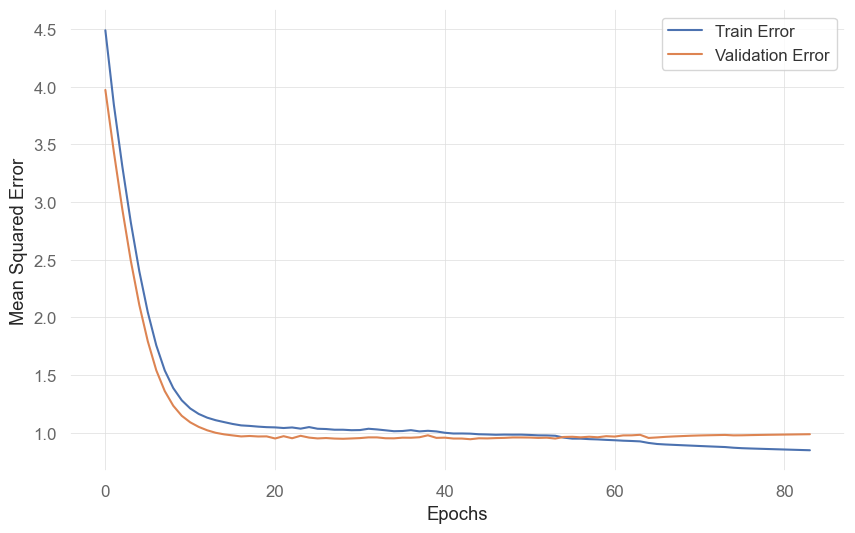

In [ ]:
class LNSimpleRNNCell_regime(layers.Layer):
    def __init__(self, units, activation="tanh", kernel_regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.state_size = units
        self.simple_rnn_cell = layers.SimpleRNNCell(units, activation=None, kernel_regularizer=l1(0.01))
        self.layer_norm = layers.LayerNormalization()
        self.activation_fn = activations.get(activation)
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        activated_outputs = self.activation_fn(self.layer_norm(outputs))
        return activated_outputs, [new_states]
    

class LNSimpleRNNModel_Regime(Model):
    def __init__(self, units, output_size, **kwargs):
        super().__init__(**kwargs)
        self.regime_dense = layers.Dense(units, activation="tanh")  # Process regime data
        self.rnn1 = layers.RNN(LNSimpleRNNCell_regime(units), return_sequences=True)
        self.dropout = layers.Dropout(0.2)
        self.rnn2 = layers.RNN(LNSimpleRNNCell_regime(units))
        self.dense = layers.Dense(output_size, activation='linear')
        
    def call(self, inputs):
        stock_input, regime_input = inputs
        regime_processed = self.regime_dense(regime_input)  # Passing regime through a dense layer
        combined_input = layers.Concatenate(axis=-1)([stock_input, regime_processed])  # Combine regime data with stock data
        x = self.rnn1(combined_input)
        x = self.dropout(x)
        x = self.rnn2(x)
        return self.dense(x)

tf.keras.backend.clear_session()
tf.random.set_seed(42)
regime_rnn_model = LNSimpleRNNModel_Regime(units=32, output_size=11)
regime_rnn_model.compile(optimizer='adamw', loss='mean_squared_error')
regime_rnn_history = regime_rnn_model.fit([X_train, X_train_regime], y_train, epochs=150, verbose=0, 
                                          validation_data=([X_val, X_val_regime], y_val), 
                                          callbacks=[early_stopping_cb, reduce_lr_cb])

# Plot training history
plt.plot(regime_rnn_history.history['loss'], label='Train Error')
plt.plot(regime_rnn_history.history['val_loss'], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

In [ ]:
regime_rnn_insample, regime_rnn_val, regime_rnn_outsample = create_regime_results(X_train, X_val, X_test, 
                                                                                  X_train_regime, X_val_regime, 
                                                                                  X_test_regime, regime_rnn_model)

rmse = np.sqrt(mean_squared_error(y_acc, regime_rnn_outsample))
print('Test RMSE: %.3f' % rmse)

regime_rnn_return_predictions = pd.concat([regime_rnn_insample, regime_rnn_val, regime_rnn_outsample], axis=0)
regime_rnn_return_predictions.index = bmk_weekly_returns.index[12:]
print(regime_rnn_return_predictions.shape)
regime_rnn_return_predictions.head()

Test RMSE: 0.036
(1719, 11)


Industrials  Health Care  Information Technology  Utilities  \
Date                                                                      
1991-03-31    -0.001342     0.001134               -0.001638  -0.003923   
1991-04-07     0.001088     0.002642                0.002633  -0.001807   
1991-04-14    -0.000582     0.001581               -0.000174  -0.003268   
1991-04-21    -0.003291    -0.002796               -0.002742  -0.003846   
1991-04-28    -0.001739    -0.001049               -0.000854  -0.003973   

            Financials  Materials  Consumer Discretionary  Real Estate  \
Date                                                                     
1991-03-31   -0.001239  -0.003443                0.002041    -0.002480   
1991-04-07    0.001913   0.002041                0.003915     0.000047   
1991-04-14   -0.001541  -0.001854                0.001997    -0.001442   
1991-04-21   -0.004186  -0.003785               -0.001430    -0.003825   
1991-04-28   -0.001567  -0.001320               -0.000702    -0.002355   

            Communication Services  Consumer Staples    Energy  
Date                                                            
1991-03-31               -0.001369         -0.001448 -0.000449  
1991-04-07                0.000507          0.000476  0.002481  
1991-04-14               -0.001231         -0.000232 -0.000812  
1991-04-21               -0.002637         -0.002929 -0.003826  
1991-04-28               -0.000839         -0.000948 -0.002460

[*********************100%%**********************]  2 of 2 completed


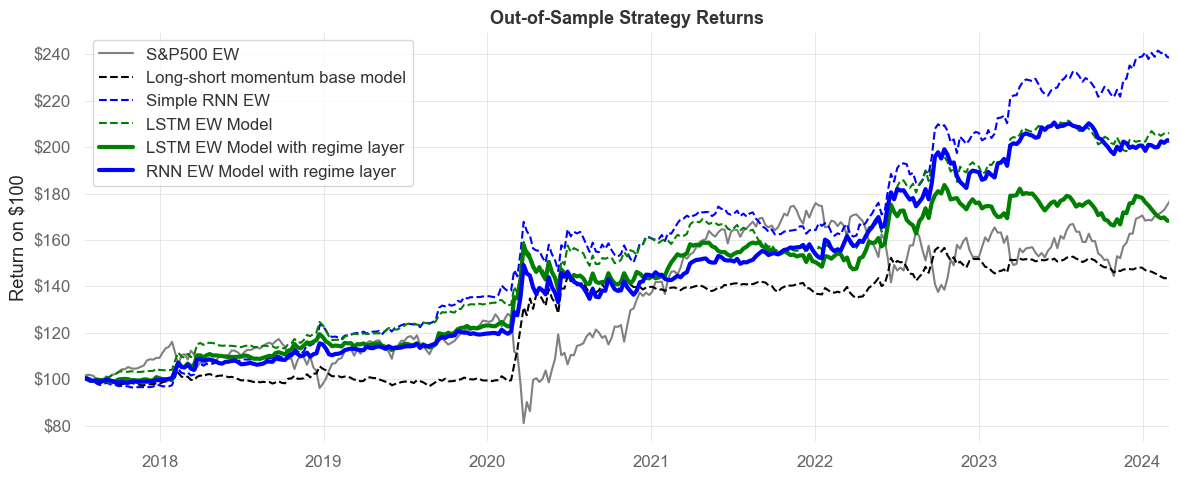

In [ ]:
# Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
regime_rnn_beta_returns = beta_adj_returns(regime_rnn_return_predictions, betas)

regime_rnn_portfolio, selected_stocks = test_model(regime_rnn_beta_returns, sector_returns, rebal_period=rebal_period)
bmks = yf.download(['^SPX','RSP'], period='max', interval='1d').Close.resample(rebal_period).last()
bmks = pd.DataFrame(bmks.pct_change())
bmks.index = pd.to_datetime(bmks.index)

# Growth of $100 for the RNN strategy versus the base models and benchmark
regime_rnn_strategy = (1+regime_rnn_portfolio['Strategy'].iloc[int(len(rnn_portfolio.index)*0.8):]).cumprod() * 100
regime_lstm_strategy = (1+regime_lstm_portfolio['Strategy'].iloc[int(len(regime_lstm_portfolio.index)*0.8):]).cumprod() * 100
bmk = (1+bmks['RSP'].loc[regime_lstm_strategy.index[0]:regime_lstm_strategy.index[-1]]).cumprod() * 100
ew_null = (1+sector_split_portfolios['Portfolio'].loc[regime_lstm_strategy.index[0]:regime_lstm_strategy.index[-1]]).cumprod() * 100

fig, ax = plt.subplots(figsize=(12,5), sharex=True)
ax.plot(bmk, label="S&P500 EW", color="grey")
ax.plot(ew_null, label="Long-short momentum base model", color="black", ls='dashed')
ax.plot(rnn_strategy, label="Simple RNN EW", color="blue", ls='dashed')
ax.plot(lstm_strategy, label="LSTM EW Model", color="green", ls='dashed')
ax.plot(regime_lstm_strategy, label="LSTM EW Model with regime layer", color="green", linewidth=3)
ax.plot(regime_rnn_strategy, label="RNN EW Model with regime layer", color="blue", linewidth=3)

ax.set_title('Out-of-Sample Strategy Returns',fontsize=13, fontweight='bold')
ax.set_ylabel('Return on $100')
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(min(regime_lstm_strategy.index),max(regime_lstm_strategy.index))
ax.legend(loc=0)
plt.tight_layout()
# plt.savefig('Graphs/oos_strategy_results.png', dpi=600)

In [ ]:
temp = pd.concat([bmk.pct_change(), ew_null.pct_change(), rnn_strategy.pct_change(), lstm_strategy.pct_change(), 
                  regime_lstm_strategy.pct_change(), regime_rnn_strategy.pct_change()], axis=1, 
                  keys=['S&P500 EW', 'LS base model', 'RNN', 'LSTM', 'LSTM w regime', 'RNN w regime'])

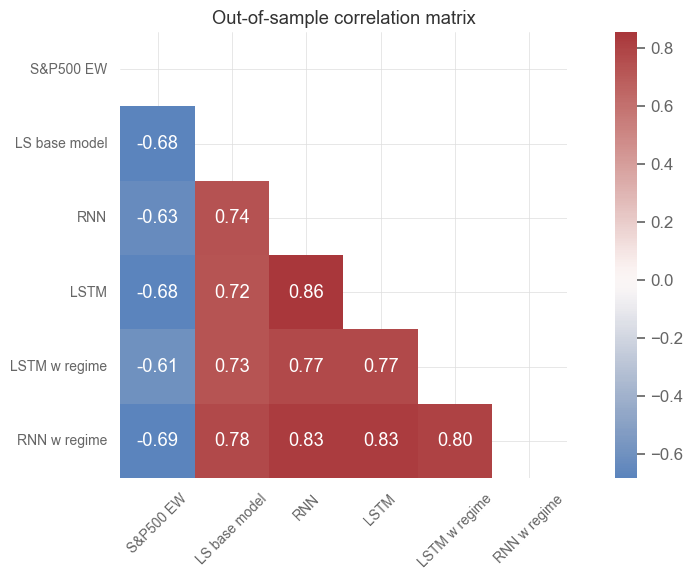

In [ ]:
corr_matrix = temp.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap='vlag')
plt.title('Out-of-sample correlation matrix')
plt.xticks(rotation=45, size=10)
plt.yticks(size=10)
plt.tight_layout()
plt.savefig('Graphs/oos_corr_matrix.png', dpi=600)

                           S&P500 EW    LS base model    RNN         LSTM        LSTM w regime    RNN w regime
-------------------------  -----------  ---------------  ----------  ----------  ---------------  --------------
Start Period               2017-07-23   2017-07-23       2017-07-23  2017-07-23  2017-07-23       2017-07-23
End Period                 2024-03-03   2024-03-03       2024-03-03  2024-03-03  2024-03-03       2024-03-03
Risk-Free Rate             3.0%         3.0%             3.0%        3.0%        3.0%             3.0%
Time in Market             100.0%       100.0%           100.0%      100.0%      100.0%           100.0%

Cumulative Return          74.84%       43.63%           137.6%      103.99%     67.51%           101.77%
CAGR﹪                     6.0%         3.85%            9.45%       7.72%       5.53%            7.6%

Sharpe                     1.06         1.15             2.48        2.19        1.52             2.05
Prob. Sharpe Ratio         77.11%    

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-02-23  2020-03-22  2020-11-08   260    -36.747600        -32.701062
2  2022-01-09  2022-10-02  2024-02-25   778    -21.794164        -20.030726
3  2018-09-30  2018-12-23  2019-06-30   274    -18.023577        -16.494754
4  2018-02-04  2018-03-25  2018-09-09   218     -9.438704         -8.666106
5  2019-08-04  2019-08-25  2019-10-27    85     -6.826027         -5.389930

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-10-09  2024-02-25  2024-03-03   512     -8.446471         -8.425692
2  2018-12-30  2019-08-25  2020-02-23   421     -8.100079         -7.753008
3  2020-05-24  2020-06-07  2020-06-07    15     -7.542133         -4.324489
4  2020-07-05  2022-04-03  2022-06-05   701     -6.657265         -6.183288
5  2022-06-26  2022-08-14  2022-09-18    85     -6.494252         -5.410763

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-03-29  2020-06-07  2021-02-28   337    -12.641930        -10.430023
2  2021-06-06  2022-03-27  2022-05-15   344     -7.415295         -7.235645
3  2022-10-09  2022-11-13  2023-02-05   120     -5.917498         -4.066133
4  2022-07-24  2022-08-21  2022-09-11    50     -4.843336         -4.341776
5  2023-08-06  2023-10-29  2023-11-26   113     -4.790958         -4.717511

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-03-29  2020-06-07  2020-12-13   260    -12.360136         -9.243831
2  2021-05-02  2022-01-02  2022-06-05   400     -8.965440         -8.714378
3  2018-12-30  2019-02-10  2019-09-01   246     -6.358132         -6.245443
4  2023-07-23  2023-11-26  2024-03-03   225     -6.327406         -6.143275
5  2022-10-09  2022-11-13  2023-03-05   148     -6.323970         -4.660628

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-03-29  2020-06-07  2021-03-21   358    -11.990055        -10.668695
2  2022-10-23  2023-10-29  2024-03-03   498     -9.499792         -9.239901
3  2021-09-05  2022-03-27  2022-04-24   232     -7.387414         -7.177030
4  2022-06-26  2022-08-14  2022-09-11    78     -7.051536         -5.068615
5  2018-12-30  2019-06-02  2019-09-08   253     -5.730160         -4.908253

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-03-29  2020-06-07  2021-03-21   358    -10.739048         -9.761927
2  2022-10-23  2022-12-04  2023-03-05   134     -8.377281         -7.690336
3  2023-06-25  2023-10-29  2024-03-03   253     -6.471480         -5.856033
4  2018-12-30  2019-01-20  2019-09-08   253     -4.432740         -4.106171
5  2022-07-10  2022-08-14  2022-09-11    64     -4.124732         -3.118507

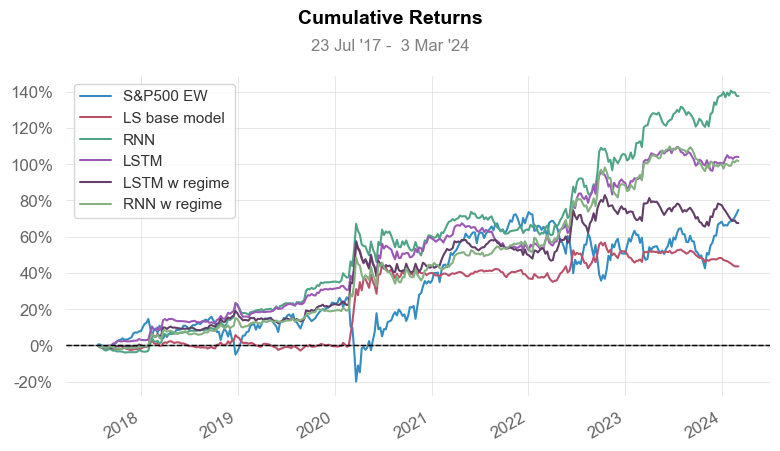

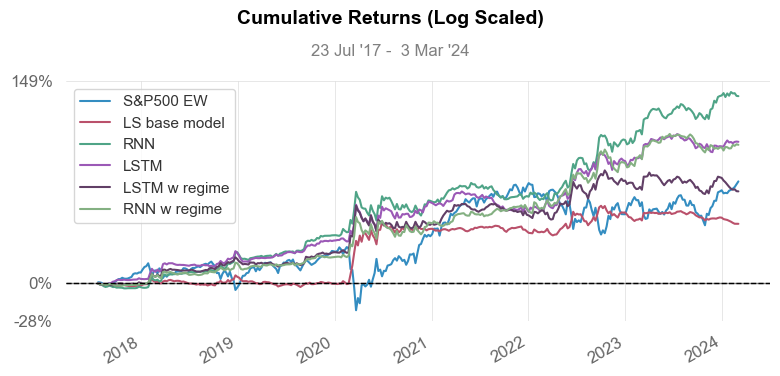

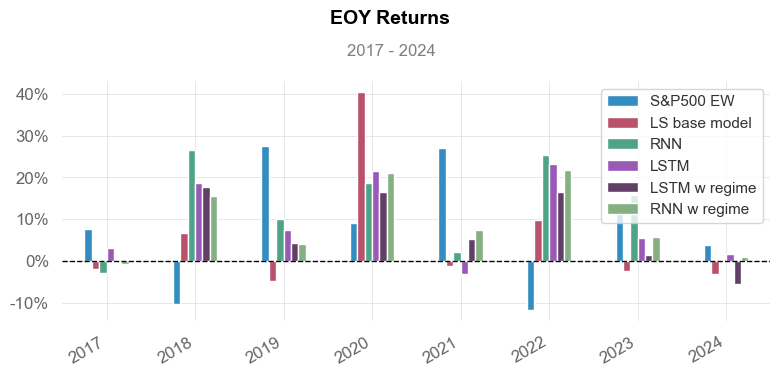

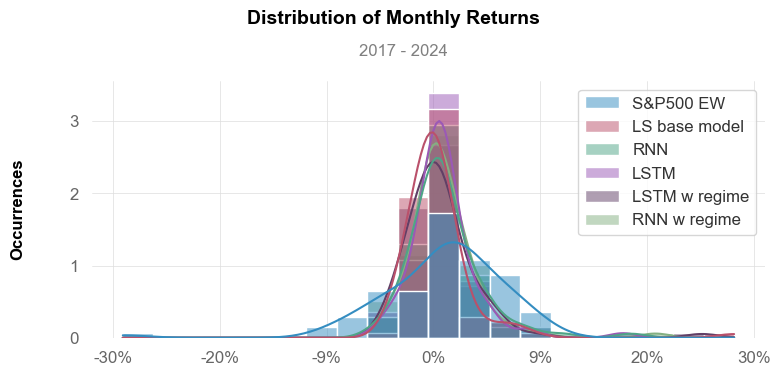

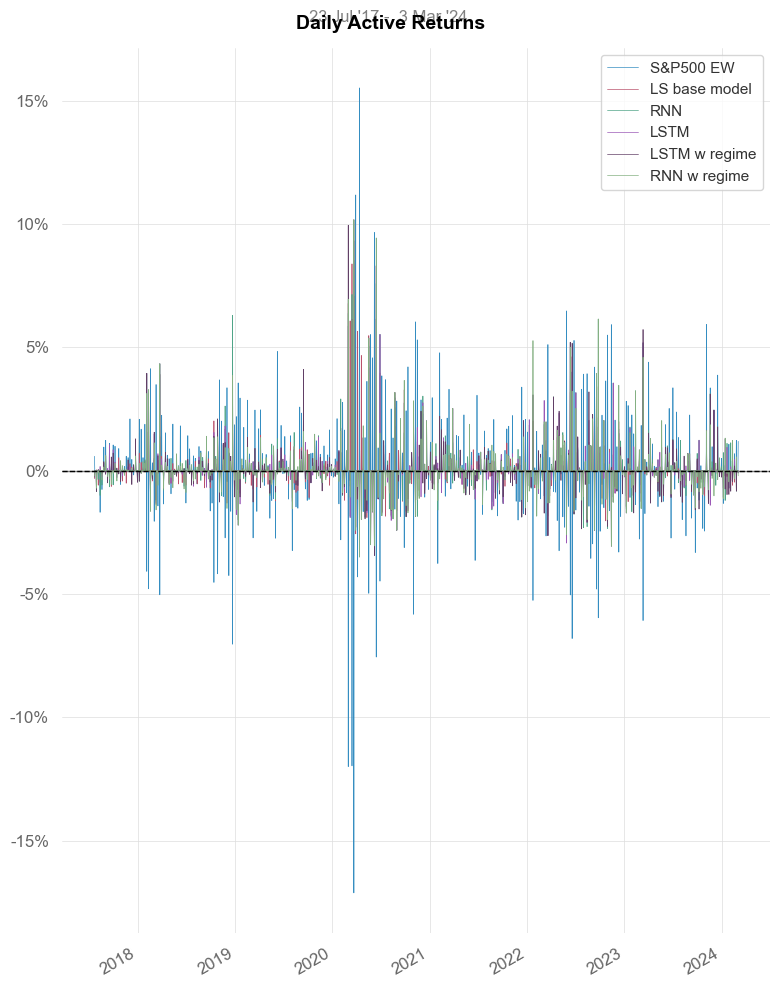

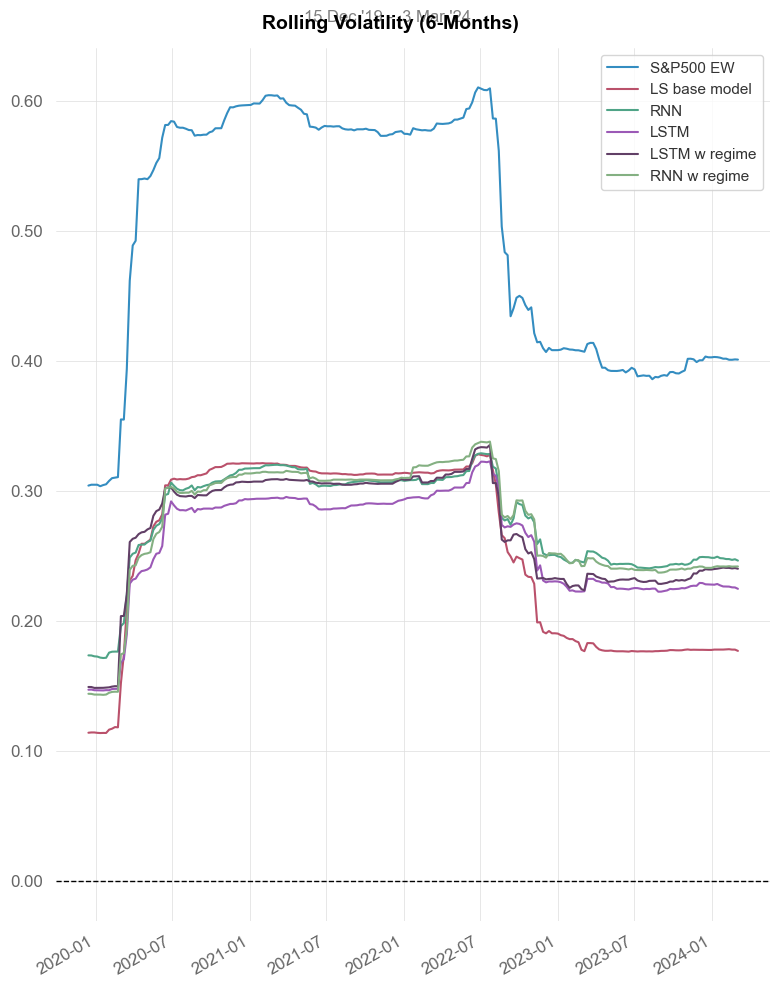

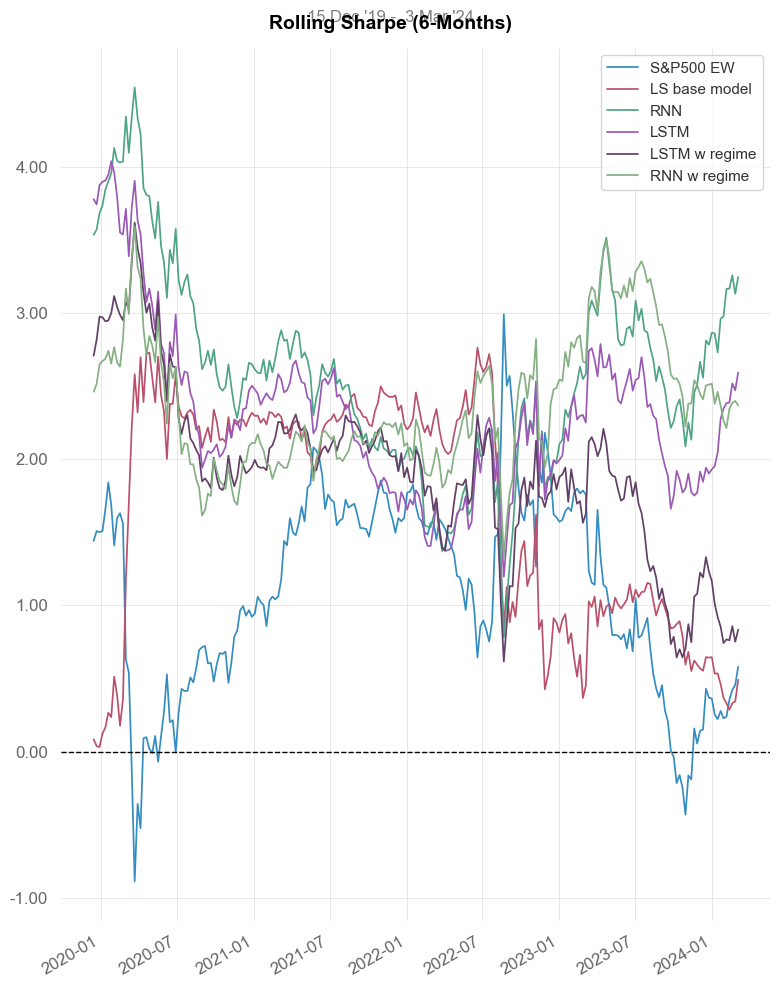

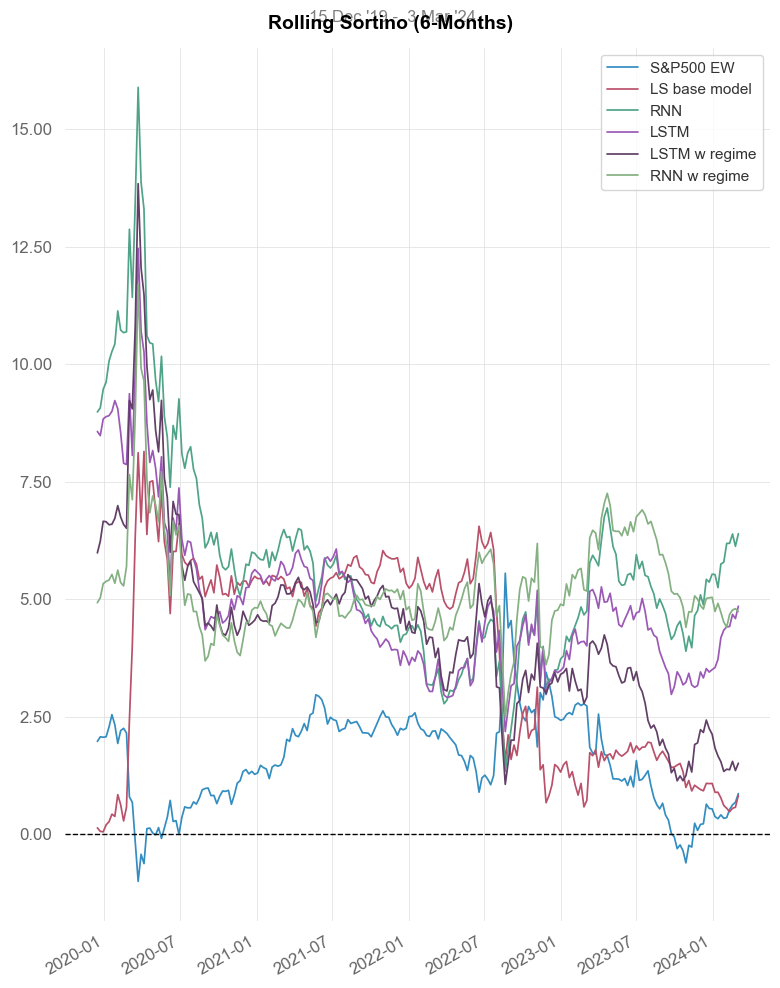

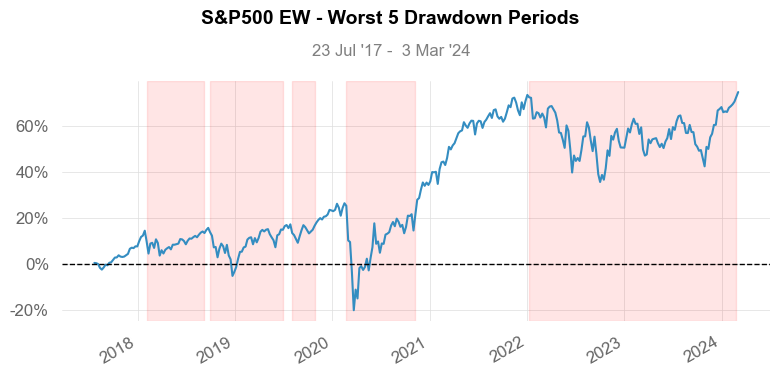

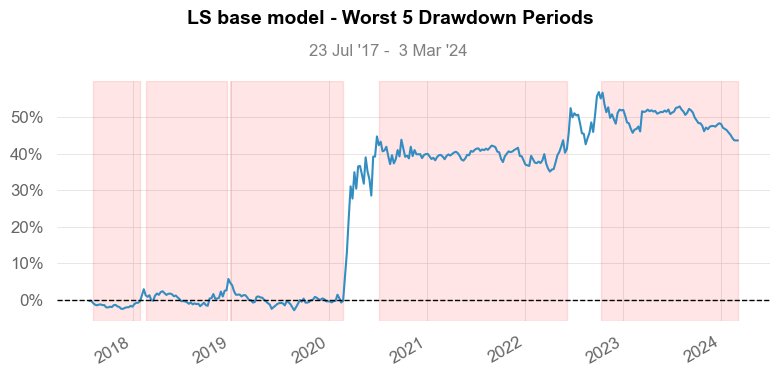

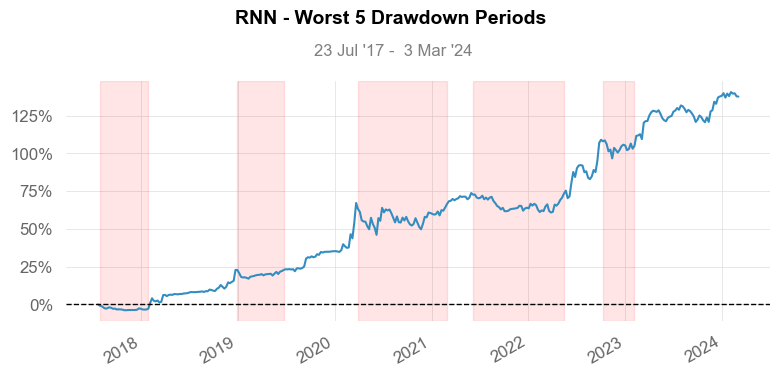

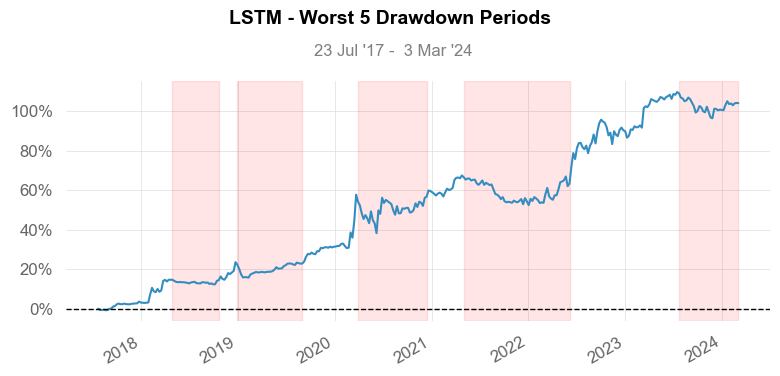

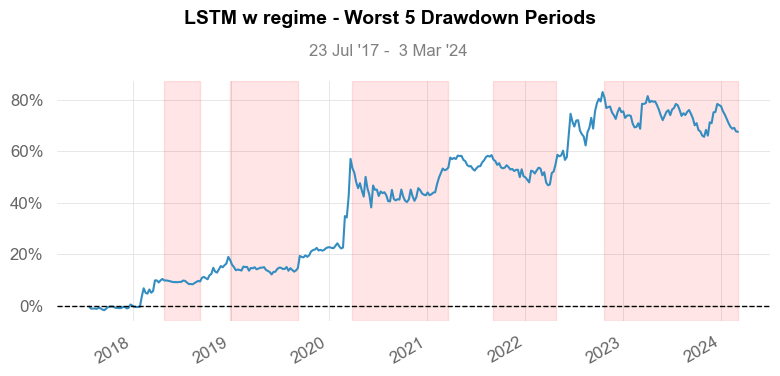

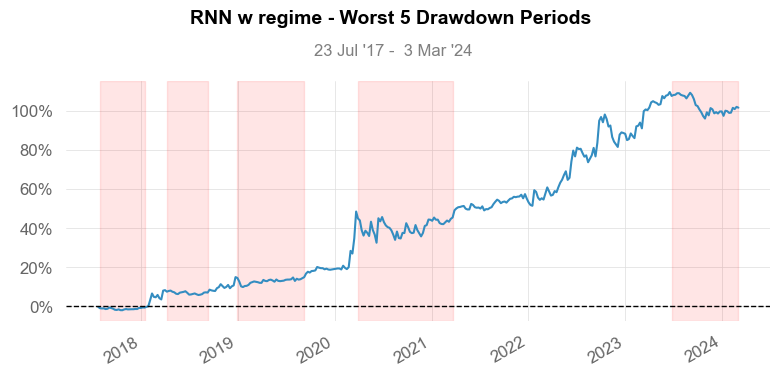

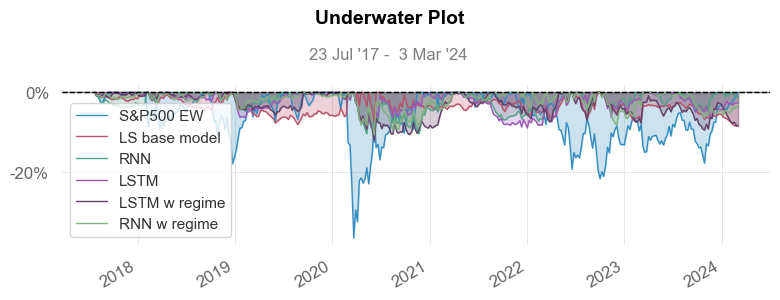

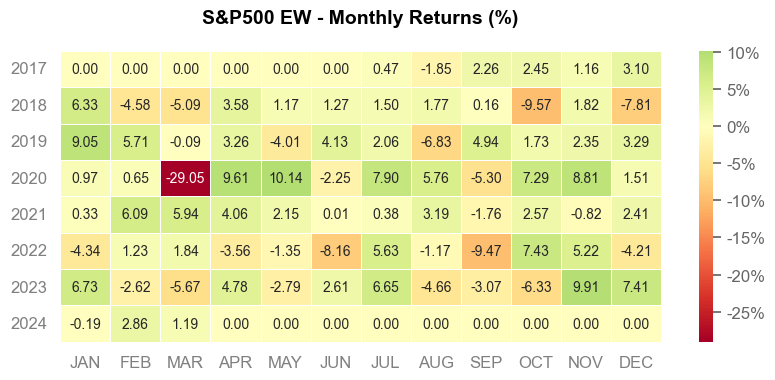

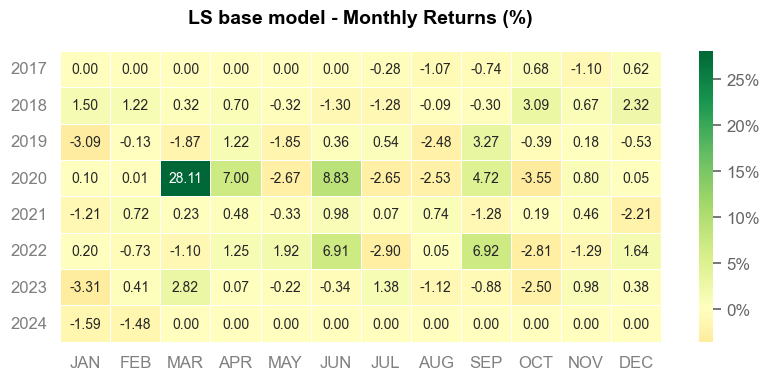

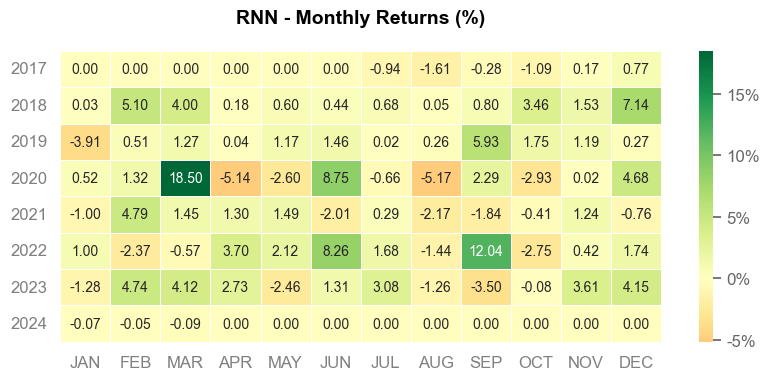

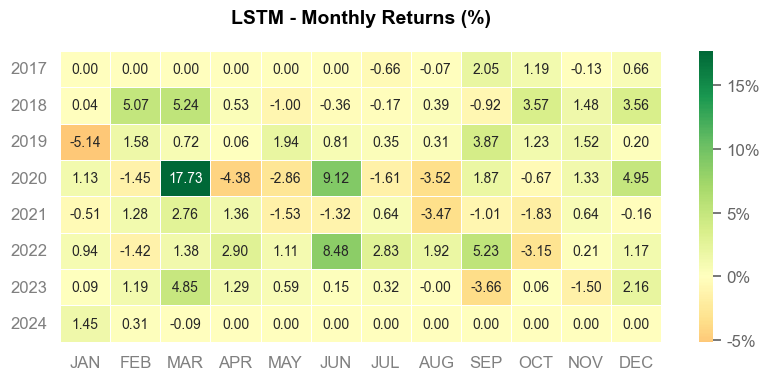

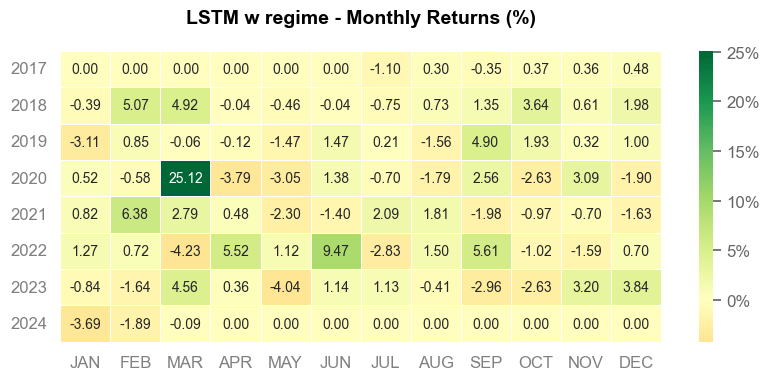

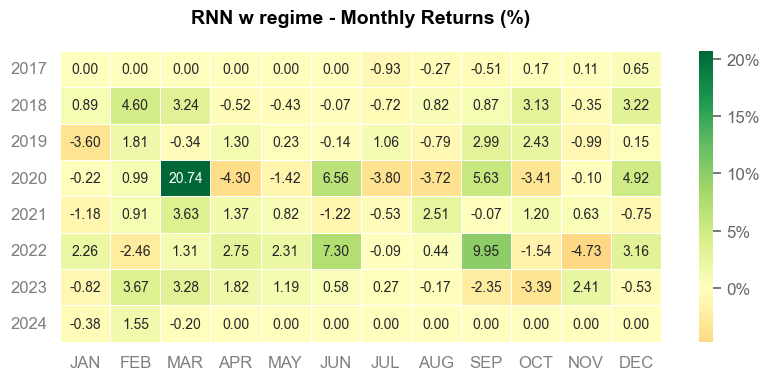

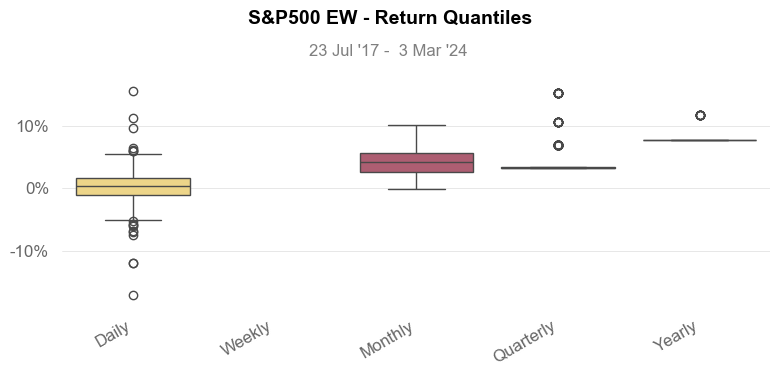

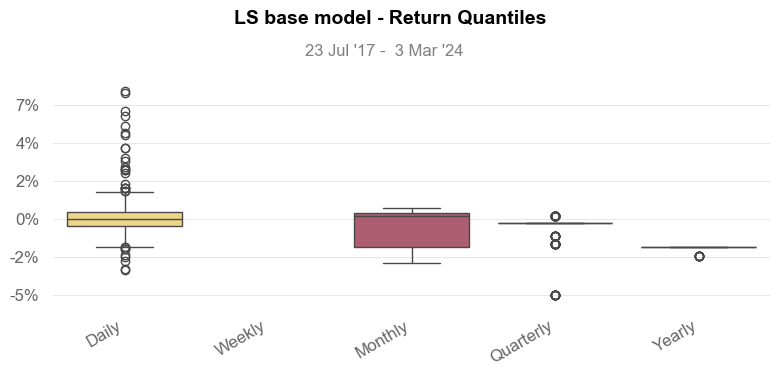

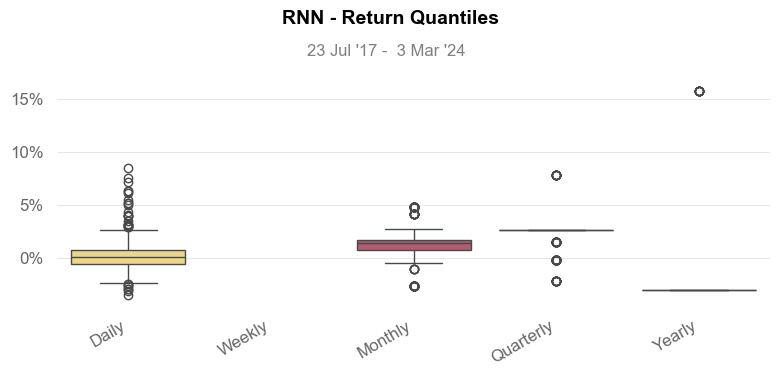

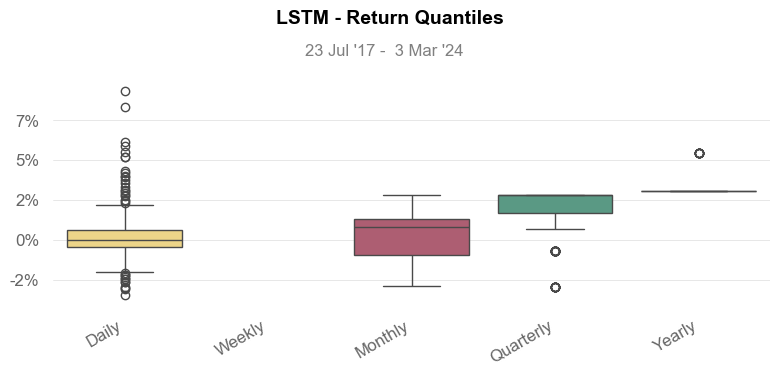

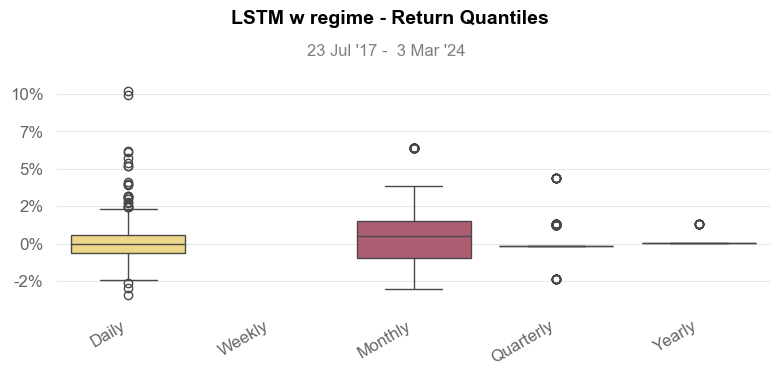

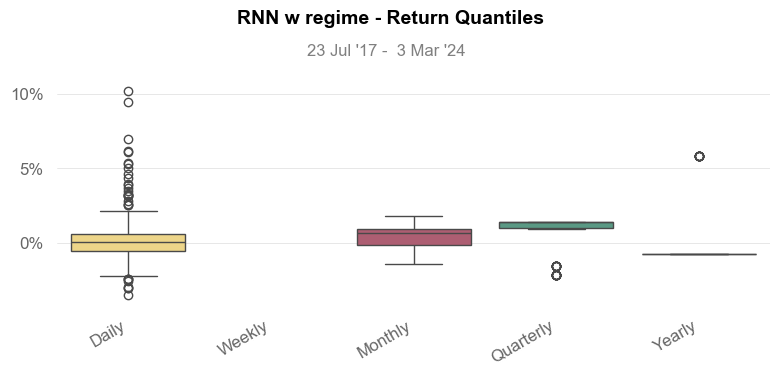

In [ ]:
import quantstats as qs

all_strategies = temp.dropna()
qs.reports.full(all_strategies, mode='full', rf=0.03)

Summary Statistics based on one run:
| Metric               | S&P500 EW | LS base model | RNN    | LSTM   | LSTM w regime | RNN w regime |
|----------------------|-----------|---------------|--------|--------|---------------|--------------|
| Cumulative Return    | 74.84%    | 43.63%        | 137.6% | 103.99%| 67.51%        | 101.77%      |
| CAGR﹪               | 6.0%      | 3.85%         | 9.45%  | 7.72%  | 5.53%         | 7.6%         |
| Sharpe               | 1.06      | 1.15          | 2.48   | 2.19   | 1.52          | 2.05         |
| Prob. Sharpe Ratio   | 77.11%    | 85.01%        | 99.79% | 99.33% | 93.85%        | 98.96%       |
| Sortino              | 1.5       | 2.37          | 5.19   | 4.51   | 3.18          | 4.39         |
| Max Drawdown         | -36.75%   | -8.45%        | -12.64%| -12.36%| -11.99%       | -10.74%      |
| Longest DD Days      | 778       | 701           | 344    | 400    | 498           | 358          |
| Volatility (ann.)    | 45.49%    | 22.62%        | 25.56% | 23.64% | 24.72%        | 24.99%       |


In [ ]:
# 100 runs
regime_rnn_results = {'sharpe': [], 'max_drawdown': [], 'total_return': [], 'RMSE': []}
num_simulations = 100
for i in range(num_simulations):

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=0)   
    regime_rnn_model = LNSimpleRNNModel_Regime(units=64, output_size=11)
    regime_rnn_model.compile(optimizer='adamw', loss='mean_squared_error') 
    regime_rnn_history = regime_rnn_model.fit([X_train, X_train_regime], y_train, epochs=150, verbose=0, 
                                              validation_data=([X_val, X_val_regime], y_val), callbacks=[early_stopping_cb, reduce_lr_cb]) 

    
    regime_rnn_insample, regime_rnn_val, regime_rnn_outsample = create_regime_results(X_train, X_val, X_test, 
                                                                                  X_train_regime, X_val_regime, 
                                                                                  X_test_regime, regime_rnn_model)

    y_acc = ss_scaler.inverse_transform(y_test)
    regime_rnn_results['RMSE'].append(np.sqrt(mean_squared_error(y_acc, regime_rnn_outsample)))

    regime_rnn_return_predictions = pd.concat([regime_rnn_insample, regime_rnn_val, regime_rnn_outsample], axis=0)
    regime_rnn_return_predictions.index = bmk_weekly_returns.index[12:]

    # Multiplying the benchmark return prediction by the beta to each stock to get the stock return prediction
    betas, sector_benchmarks = calculate_rolling_beta(prices, window_size=60, resample=rebal_period)
    beta_returns_prediction = beta_adj_returns(regime_rnn_return_predictions, betas)

    regime_rnn_portfolio, selected_stocks = test_model(beta_returns_prediction, sector_returns, rebal_period=rebal_period)
    regime_rnn_strategy = (1+regime_rnn_portfolio['Strategy'].iloc[int(len(rnn_portfolio.index)*0.8):]).cumprod() * 100
    regime_rnn_results['sharpe'].append(qs.stats.sharpe(regime_rnn_strategy, rf=0.03))
    regime_rnn_results['max_drawdown'].append(qs.stats.max_drawdown(regime_rnn_strategy))
    regime_rnn_results['total_return'].append(regime_rnn_strategy[-1])
    if i % 10 == 0:
        print(f'Simulation {i} complete.')

Simulation 0 complete.
Simulation 10 complete.
Simulation 20 complete.
Simulation 30 complete.
Simulation 40 complete.
Simulation 50 complete.
Simulation 60 complete.
Simulation 70 complete.
Simulation 80 complete.
Simulation 90 complete.


In [ ]:
regime_rnn_portfolio.to_csv('regime_rnn_sector_results.csv', index=True)

- **Each model was also tested to predict single stock returns (without success). Code is available upon request.**
- **Excel sheet of all results available upon request**

## Calculating Average Statistics from 100 runs

In [ ]:
results = [rnn_results, lstm_results, regime_rnn_results, regime_lstm_results]

# save results to csv
# for i, result in enumerate(results):
#     pd.DataFrame(result).to_csv(f'FinalModelsResults/results_{i}.csv', index=False)

In [ ]:
av_sharpe = [qs.stats.sharpe(ew_null)]
av_max_drawdown = [qs.stats.max_drawdown(ew_null)]
av_total_return = [(ew_null[-1]-100)/100]
av_RMSE = [None,]

for model in results:
    av_sharpe.append(np.mean(model['sharpe']))
    av_max_drawdown.append(np.mean(model['max_drawdown']))
    av_total_return.append((np.mean(model['total_return'])-100)/100)
    av_RMSE.append(np.mean(model['RMSE']))


results_df = pd.DataFrame({'Model': ['Null model','Simple RNN', 'LSTM', 'RNN w regime', 'LSTM w regime'],
                            'Average Sharpe Ratio': av_sharpe,
                            'Average Max Drawdown': av_max_drawdown,
                            'Average Total Return': av_total_return,
                            'Average RMSE': av_RMSE})

results_df['Average Max Drawdown'] = results_df['Average Max Drawdown'].round(3)
results_df.loc[:,['Average Sharpe Ratio', 'Average RMSE', 'Average Total Return']] = results_df.loc[:,['Average Sharpe Ratio', 'Average RMSE', 'Average Total Return']].round(2)
results_df['Average Max Drawdown'] = results_df['Average Max Drawdown'].apply(lambda x: f'{x*100}%')
results_df['Average Total Return'] = results_df['Average Total Return'].apply(lambda x: f'{x*100}%')
results_df['Average RMSE'][0] = '-'
# results_df.to_csv('final_model_results.csv', index=False)

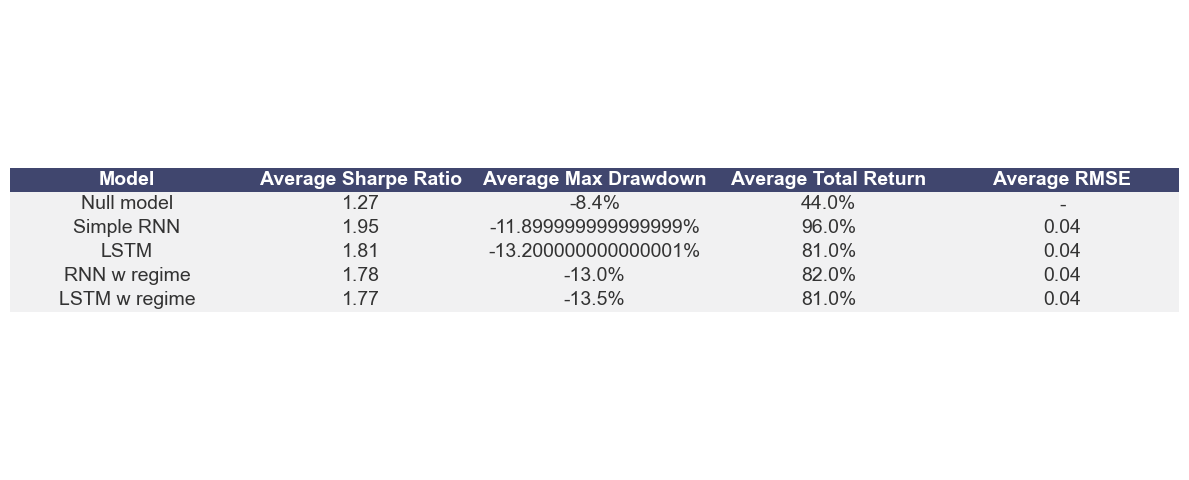

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)  # Increase scale to make table larger
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)
    if key[0] == 0:  # Bold font for the header
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')
    else:
        cell.set_facecolor('#f1f1f2')

plt.tight_layout()
# plt.savefig('results_table.png', bbox_inches='tight', dpi=600)

## Robustness checks

Sharpe ratio to t-test: Evaluating Trading Strategies Harvey et al. 2014

In [ ]:
from scipy.stats import t

# T-statistcis
t_stats = (np.array(av_sharpe)) * np.sqrt(6.66) # 6.66 years roughly in OOS period, including 3% risk-free rate


# Degrees of freedom
df = regime_rnn_return_predictions.shape[0] - regime_rnn_return_predictions.shape[1] # n - p
critical_values = {
    '99.9%': t.ppf(0.999, df),
    '99.99%': t.ppf(0.9999, df),
    '99.999%': t.ppf(0.99999, df)
} # includes Bonferroni correction - 10%, 1%, 0.1%

i=0
for t in t_stats:
    print(av_sharpe[i])
    print(f'T-statistic: {t:.2f}')
    for k, v in critical_values.items():
        if t > v:
            print(f'Reject the null hypothesis at the {k}% level')
        else:
            print(f'Fail to reject the null hypothesis at the {k}% level')
    print('\n')
    i+=1

1.2746902080182896
T-statistic: 3.29
Reject the null hypothesis at the 99.9%% level
Fail to reject the null hypothesis at the 99.99%% level
Fail to reject the null hypothesis at the 99.999%% level


1.9511954175151158
T-statistic: 5.04
Reject the null hypothesis at the 99.9%% level
Reject the null hypothesis at the 99.99%% level
Reject the null hypothesis at the 99.999%% level


1.8140728005479116
T-statistic: 4.68
Reject the null hypothesis at the 99.9%% level
Reject the null hypothesis at the 99.99%% level
Reject the null hypothesis at the 99.999%% level


1.7769422062655382
T-statistic: 4.59
Reject the null hypothesis at the 99.9%% level
Reject the null hypothesis at the 99.99%% level
Reject the null hypothesis at the 99.999%% level


1.7747339857264484
T-statistic: 4.58
Reject the null hypothesis at the 99.9%% level
Reject the null hypothesis at the 99.99%% level
Reject the null hypothesis at the 99.999%% level


